# **MultiGraph QA**

Developed by Roberto Giordano

## Introduction

This project develops a dual pipeline to process scientific documents from ArXiv, focusing on two distinct methodologies: a multimodal approach for question answering (QA) and a graph-based framework for advanced reasoning.

---

### Problem Statement
The goal is to create a Google Colab notebook that explores two separate methods for addressing information retrieval and reasoning tasks:

1. **Multimodal Approach for QA**: Retrieve and utilize content (text and visuals) from ArXiv documents to evaluate performance quantitatively in a multiple-choice QA task.
2. **Graph-based Reasoning**: Build and utilize a knowledge graph from ArXiv documents to answer complex questions (e.g., multi-hop reasoning and aggregation) using advanced reasoning technologies.

---

#### **Module 1: Multimodal Approach for QA**
- **Focus**: Starting from extracted figures from PDFs, evaluate the performance on a multiple-choice QA task, comparing late-chunking and late-interaction methods using multi-modal and text-only models.

- **Technologies**:
  - Multimodal models: colqwen2-v0.1
  - Text-only retrieval with late interaction: colbert-ir/colbertv2.0.
  - Text-only retrieval with late chunking: jinaai/jina-embeddings-v2-base-en.
  
- **Output**:
  - Evaluation metrics such as Precision@k, MRR, and downstream accuracy on QA tasks.
  - Numerical results on the performance of various retrieval approaches.
  - Comparative tables and graphs.

This notebook is built so that each section could be run as standalone, for this reason some imports are repeated.

#### **Module 2: GraphRAG on ArXiv docs**
See this [file](graphRAG.ipynb) for the implementation. The modules have been separated to improve readability.

## Setup

In [ ]:
!pip install datasets
!pip install pillow
!pip install matplotlib
!pip install transformers torch datasets byaldi
!pip install -q pdf2image
!pip install git+https://github.com/huggingface/transformers.git
!pip install qwen-vl-utils
!pip install flash-attn
!pip install byaldi
!pip install torch torchvision
!pip install ragatouille
!pip uninstall --y faiss-cpu & pip install faiss-gpu
!pip install seaborn

In [ ]:
#!sudo apt-get install -y poppler-utils

In [7]:
# Import required libraries
import os

from datasets import load_dataset

import torch
import tqdm

import requests
import re

from concurrent.futures import ThreadPoolExecutor, as_completed

from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import io
import ast

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [8]:
import transformers

from byaldi import RAGMultiModalModel
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
import numpy as np

from ragatouille import RAGPretrainedModel
from ragatouille.utils import get_wikipedia_page

In [9]:
try:
    from google.colab import drive
    drive.mount('/content/drive')

    PATH='/content/drive/MyDrive/MultiGraphQA/'
except:
    PATH='./'

print(PATH)

Mounted at /content/drive
/content/drive/MyDrive/MultiGraphQA/


In [10]:
# Set device
device = "mps" if torch.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")

Using device: cuda


## Load Original Dataset

The dataset consists of images extracted from ArXiv documents. Each image is associated with a question and multiple possible answers. Additionally, the dataset includes the correct (golden) answer for each question.

In [ ]:
"""
@misc{li2024multimodal,
            title={Multimodal ArXiv: A Dataset for Improving Scientific Comprehension of Large Vision-Language Models},
            author={Lei Li and Yuqi Wang and Runxin Xu and Peiyi Wang and Xiachong Feng and Lingpeng Kong and Qi Liu},
            year={2024},
            eprint={2403.00231},
            archivePrefix={arXiv},
            primaryClass={cs.CV}
        }
        """

# Load parquet files inside folder data
ds = load_dataset('parquet', data_files=PATH+'data/test-00000-of-00001.parquet')

We will extract all the images from the database and save them in a local folder. This step will be useful later for generating image embeddings.

In [ ]:
# Save all images
os.makedirs(PATH+'data/images')

for i, item in enumerate(ds['train']):
    item['image'].save(f'data/{item["image_filename"]}')

Let's inspect a single element to understand its structure. The image filename can be used to trace back to the original paper.

In [ ]:
ds['train'][0]

{'query': 'Based on the graph, what is the impact of correcting for fspec not equal to 1 on the surface density trend?',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1621x1191>,
 'image_filename': 'images/1810.10511_2.jpg',
 'options': "['A. Correction causes a significant increase in surface density across all radii.', 'B. Correction results in a decrease in surface density for larger radii.', 'C. Correction causes the surface density to converge with the fspec = 1 case at larger radii.', 'D. Correction does not affect the surface density trend at all.', '-']",
 'answer': 'C',
 'page': '',
 'model': 'gpt4V',
 'prompt': '',
 'source': 'arxiv_qa'}

## Download sources pdf

The PDF sources will be useful in the second part of this project, specifically for implementing GraphRAG. The pipeline will be built using a subset of these documents to establish at least a preliminary baseline.

In [ ]:
def download_arxiv_pdf(arxiv_id: str, save_path: str) -> None:
    """
    Download PDF from arXiv given the arXiv ID.

    Args:
        arxiv_id (str): arXiv ID.
        save_path (str): Path to save the PDF.

    Raises:
        Exception: If failed to download PDF.
    """
    url = f"https://arxiv.org/pdf/{arxiv_id}"
    response = requests.get(url)
    if response.status_code == 200:
        with open(save_path, 'wb') as file:
            file.write(response.content)
        print(f"PDF downloaded successfully: {save_path}")
    else:
        raise Exception(f"Failed to download PDF. Status code: {response.status_code}")
    

# This is a wrapper around the above function to include some logic to handle the case where the arXiv ID is not in the expected format.
def download_pdf(item: dict, save_path: str) -> str:
    """
    Wrapper around download_arxiv_pdf to handle the case where the arXiv ID is not in the expected format.

    Args:
        item (dict): Dataset item.
        save_path (str): Path to save the PDF.

    Returns:
        str: arXiv ID in case of error
    """

    # Extract the id from the image filename
    arxiv_id = item['image_filename'].replace('images/', '').split('_')[0]

    # If has not been downloaded yet, download it
    if not os.path.exists(f"{save_path}{arxiv_id}.pdf"):
        # Try once, if fails, try again with another format
        try:
            download_arxiv_pdf(arxiv_id, f"{save_path}{arxiv_id}.pdf")
        except Exception as e:
            try:
                arxiv_id_regex = re.compile(r'([a-z\-]+)(\d{7})')
                match = arxiv_id_regex.match(arxiv_id)
                arxiv_id = match.group(1) + '/' + match.group(2)
                download_arxiv_pdf(arxiv_id, f"{save_path}{arxiv_id}.pdf")
            except Exception:
                return arxiv_id  # Return arXiv ID in case of error
    return None


In [ ]:
# Define path to save PDFs
save_path = PATH + "data/docs/"
os.makedirs(save_path, exist_ok=True)

# Create a list to store errors, could be useful to retry
errors = []

# Parallel download of PDFs
with ThreadPoolExecutor() as executor:
    future_to_item = {executor.submit(download_pdf, item, save_path): item for item in ds['train']}
    for future in as_completed(future_to_item):
        result = future.result()
        if result:
            errors.append(result)
            print(f"Failed to download PDF: {result}")

print("Download completed with the following errors:", errors)

Failed to download PDF: cond-mat/0603861
Failed to download PDF: 2304.04203
Failed to download PDF: quant-ph/9912091
Failed to download PDF: astro-ph/0207226
Failed to download PDF: cond-mat/0010301
Failed to download PDF: cond-mat/0201239
Failed to download PDF: cond-mat/0404614
Failed to download PDF: physics/0603179
Failed to download PDF: cs/0505008
Failed to download PDF: cond-mat/0312100
Failed to download PDF: cond-mat/0507316
Failed to download PDF: nucl-th/0408026
Failed to download PDF: cond-mat/0303467
Failed to download PDF: astro-ph/9911146
Failed to download PDF: astro-ph/0407096
Failed to download PDF: astro-ph/0302390
Failed to download PDF: cond-mat/0011289
Failed to download PDF: cond-mat/0304485
Failed to download PDF: cond-mat/0103207
Failed to download PDF: astro-ph/0309681
Failed to download PDF: cond-mat/0610297
Failed to download PDF: cond-mat/0306096
Failed to download PDF: quant-ph/0306172
Failed to download PDF: astro-ph/0007066
Failed to download PDF: 1605.0

In [ ]:
errors

['astro-ph/0207226',
 'quant-ph/9912091',
 'cond-mat/0010301',
 'cond-mat/0201239',
 'cond-mat/0404614',
 'physics/0603179',
 'cs/0505008',
 'cond-mat/0603861',
 '2304.04203',
 'cond-mat/0507316',
 'astro-ph/0407096',
 'nucl-th/0408026',
 'astro-ph/9911146',
 'cond-mat/0312100',
 'cond-mat/0303467',
 'astro-ph/0302390',
 'cond-mat/0011289',
 'cond-mat/0304485',
 'astro-ph/0309681',
 'cond-mat/0306096',
 'cond-mat/0610297',
 'cond-mat/0103207',
 'quant-ph/0306172',
 'astro-ph/0007066',
 'cond-mat/9912475',
 'cond-mat/0209400',
 'patt-sol/9807001',
 'cond-mat/0309427',
 '1605.07294',
 '2009.06919',
 '2112.01135',
 '1603.07511',
 '2211.04473',
 '2203.11482',
 '1109.0247',
 'astro-ph/0503040',
 '2109.02264',
 '2302.08063',
 'cond-mat/0305642',
 'cond-mat/0112488',
 '0806.4457',
 '1602.08753',
 '1103.0213',
 '2112.07507',
 '2001.00631',
 '1208.5149',
 '2210.17322',
 '2302.14665',
 'cond-mat/0207431',
 '1508.07972',
 '1110.0473']

In [ ]:
len(errors)

51

These 51 elements cannot be accessed openly. However, since we are focusing on a subset of documents and have approximately 450 available, this dataset is perfectly suitable for our needs.

## Generation of images description

The dataset lacks image descriptions. While Vidore provided similar datasets with descriptions, their quality was insufficient. Hence, a more effective approach is to generate high-quality descriptions using a multimodal model and store them for future use.  

Text descriptions are essential as we plan to work with ColBERT and Jinai models, which are text-only large language models.

In [ ]:
# Define the multi-modal model and load it
multimodal_model_name = "Qwen/Qwen2-VL-2B-Instruct"
multimodal_model = Qwen2VLForConditionalGeneration.from_pretrained(
                                                        multimodal_model_name,
                                                        trust_remote_code=True,
                                                        torch_dtype=torch.bfloat16).to(device)
processor = AutoProcessor.from_pretrained(multimodal_model_name, trust_remote_code=True)

In [ ]:
def create_messages(img):
    """
    Create messages to be used in the conversation.

    Args:
        img: Image to be used in the conversation. Could be a path to an image or a PIL image.

    Returns:
        list: List of messages.
    """
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": img,
                    "max_pixels": 720**2,
                },
                {
                    "type": "text",
                    "text":
                        "Based on the image, provide a detailed scientific description of the graph."
                },
            ],
        }
    ]

    return messages


In [ ]:
def invoke_generation(messages: list):
    """
    Create a pipeline to generate a response based on the given messages.

    Args:
        messages: List of messages to be used in the conversation.

    Returns:
        str: Generated response.
    """

    print('Applying vision template...')
    # Apply a chat template to the messages without tokenizing and add a generation prompt
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )

    print('Tokenizing text...')
    # Process vision information from the messages to get image and video inputs
    image_inputs, video_inputs = process_vision_info(messages)

    print('Preparing inputs...')
    # Prepare the inputs for the model by combining text, images, and videos
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",  # Return the inputs as PyTorch tensors
    )

    print('Moving inputs to device...')
    # Move the inputs to the specified device (e.g., GPU)
    inputs = inputs.to(device)

    print('Generating output...')
    # Generate output IDs from the model with a maximum of 500 new tokens
    generated_ids = multimodal_model.generate(**inputs, max_new_tokens=500)

    print('Decoding output...')
    # Trim the generated IDs to remove the input IDs from the beginning
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]

    print('Decoding text...')
    # Decode the trimmed generated IDs to get the output text
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    print('Output:', output_text)
    print('\n\n ---------------------------------------- \n\n')
    return output_text

In [ ]:
# Function to process a single example
def process_item(example):
    """
    Process a single item from the dataset.

    Args:
        example: Example item from the dataset.

    Returns:
        dict: Processed item.
    """

    try:
        img = example['image']  # Extract the image
        messages = create_messages(img)  # Create messages
        output_text = invoke_generation(messages)  # Generate output text

        return {"image_filename": example["image_filename"], "output_text": output_text}
    
    except Exception as e:
        print(f"Error processing item: {e}")

# Function to save processed data as a checkpoint
def save_checkpoint(processed_data, checkpoint_file):
    """
    Save processed data as a checkpoint.

    Args:
        processed_data: Processed data to save.
        checkpoint_file (str): Checkpoint file to save the processed data.
    """

    df = pd.DataFrame(processed_data)
    df.to_parquet(checkpoint_file, index=False)
    print(f"Checkpoint saved: {len(processed_data)} items to {checkpoint_file}")

# Process dataset in batches with checkpoints
def process_dataset_with_checkpoints(ds, checkpoint_save_size=10, output_file="data/processed_images.parquet"):
    """
    Process a dataset in batches with checkpoints.
    Checkpoints ensure that the processed data is saved periodically to avoid losing progress.

    Args:
        ds: Dataset to process.
        checkpoint_save_size (int): Number of items to process before saving a checkpoint.
        output_file (str): Output file to save the processed data.

    Returns:
        list: List of processed items.
    """

    train_data = ds['train']  # Access training data
    processed_items = []  # To store processed items
    checkpoint_file = output_file

    for idx, example in enumerate(tqdm.tqdm(train_data)):
        processed_item = process_item(example)
        processed_items.append(processed_item)

        print(processed_items)

        # Save every checkpoint_save_size items or at the end
        if (idx + 1) % checkpoint_save_size == 0 or (idx + 1) == len(train_data):
            save_checkpoint(processed_items, checkpoint_file)

    return processed_items

In [ ]:
# Run the processing
processed_dataset = process_dataset_with_checkpoints(
    ds, checkpoint_save_size=10, output_file="data/processed_images.parquet"
)

## Embedding creation

In information retrieval and processing of long documents, effectively managing and embedding text segments—known as "chunking"—is crucial for maintaining contextual integrity and ensuring accurate retrieval. Below is an overview of three chunking methodologies: **normal chunking**, **late interaction**, and **late chunking**.

![Chunking Strategies](./images/chunking-strategies.png) 

Source: https://weaviate.io/blog/late-chunking

**Normal Chunking (Traditional Chunking):**

In this conventional approach, a long document is divided into smaller, manageable chunks based on predetermined criteria, such as a fixed number of tokens or sentences. Each chunk is then independently embedded using an embedding model, resulting in separate vector representations for each segment. While this method simplifies processing, it often fails to capture the broader context of the entire document. Consequently, interdependencies and relationships between chunks may be overlooked, leading to potential inaccuracies in tasks like information retrieval or question answering. 

**Late Interaction (ColBERT Approach):**

The late interaction strategy, exemplified by the ColBERT (Contextualized Late Interaction over BERT) model, enhances retrieval by preserving token-level embeddings and deferring their interaction until the retrieval stage. In this method, both the document and the query are tokenized, and embeddings are generated for each token. Instead of aggregating these embeddings into a single vector, the model retains all token embeddings. During retrieval, it computes similarities between query and document token embeddings, allowing for fine-grained matching. While this approach improves precision by considering detailed token interactions, it demands substantial storage and computational resources due to the large number of embeddings involved. 

**Late Chunking:**

Late chunking reverses the traditional process by first embedding the entire document using a long-context embedding model capable of handling extensive token sequences. After generating embeddings for all tokens in the document, it segments these embeddings into chunks based on the original text's structure. Each chunk's embedding is derived by pooling the token embeddings within its boundaries. This technique ensures that each chunk's representation encompasses the full document's context, preserving inter-chunk relationships and enhancing retrieval accuracy. Moreover, late chunking balances precision and resource efficiency, as it requires storage comparable to normal chunking but achieves contextual awareness akin to more resource-intensive methods like late interaction. 

In this context, we will evaluate and compare late interaction techniques utilizing both visual and text-based models, as well as the late chunking approach implemented with JinaAI.

### Create visual embedding with late interaction using colqwen2-v0.1

The **Vidore/ColQwen2** model is a state-of-the-art multimodal model designed to handle both textual and visual inputs, enabling advanced reasoning and information retrieval tasks. It combines the strengths of language models and vision transformers, making it particularly effective for tasks requiring a deep understanding of text-image relationships, such as question answering (QA) and document analysis. This model is optimized for performance in multimodal pipelines, offering robust embedding capabilities and seamless integration for applications like late interaction and late chunking. 

It's worth noting that late chunking can effectively be derived from late interaction by simply pooling the embeddings at a later stage. This approach leverages the detailed token-level embeddings produced during late interaction, aggregating them afterward to form chunk-level representations while preserving contextual richness.

In [ ]:
RAG = RAGMultiModalModel.from_pretrained("vidore/colqwen2-v0.1-merged", device=device)

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


In [ ]:
# Embed all the images saved in the previous step

try:
    RAG.index(
    input_path="data/images/", # The path to your documents
    index_name='colqwen2-v0.1-merged-arxiv_qa', # It will create an index at .byaldi/index_name
    store_collection_with_index=False, # Whether the index should store the base64 encoded documents.
    overwrite=False # Whether to overwrite an index if it already exists. If False, it'll return None and do nothing if `index_root/index_name` exists.
)
except ValueError:
    # If the index already exists, load it on cpu to avoid memory issues
    RAG=RAG.from_index('colqwen2-v0.1-merged-arxiv_qa', device='cpu')

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


/Users/robertogiordano/Desktop/MultiGraphQA/.conda/lib/python3.11/site-packages/byaldi/colpali.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.indexed_embeddings.

In [ ]:
# Try to search for a question

text_query = 'Based on the graph, what is the impact of correcting for fspec not equal to 1 on the surface density trend?'
results = RAG.search(text_query, k=1)
results

[{'doc_id': 245, 'page_num': 1, 'score': 24.875, 'metadata': {}, 'base64': None}]

In [ ]:
# Retrieve the image name diven the doc_id of the index
image_name='/'.join(RAG.get_doc_ids_to_file_names()[results[0]['doc_id']].split('/')[-2:])

In [ ]:
# Find image_name in ds
for i, item in enumerate(ds['train']):
    if item['image_filename']==image_name:
        break

### Create textual embedding with late interaction using Ragatoutille colbert-ir/colbertv2.0

The **ColBERTv2.0** model, developed by **colbert-ir**, is an advanced neural retrieval system designed for highly efficient and precise information retrieval. It builds upon the **ColBERT (Contextualized Late Interaction over BERT)** framework, which utilizes late interaction to retain rich token-level representations rather than compressing them into a single embedding. This architecture enables fine-grained matching between queries and documents, enhancing retrieval performance.  

ColBERTv2.0 improves upon its predecessor by optimizing efficiency, reducing memory requirements, and supporting faster indexing and retrieval without compromising accuracy. It is particularly well-suited for tasks involving dense retrieval, multi-hop reasoning, and retrieval-augmented generation (RAG) systems.

In [ ]:
# Load the description of the images
ds=load_dataset('parquet', data_files=PATH+'data/processed_images.parquet')

# Filter the generated text
output_text=ds['train'].to_pandas()['output_text']
output_text=output_text.apply(lambda x: x[0])
output_text=output_text.values.tolist()

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
# Print the first 3
output_text[:3]

['The graph in the image is a plot of the surface density of a hypothetical object as a function of its radius. The surface density is measured in units of \\(\\log \\Sigma [h^{-2} \\, \\text{Mpc}^{-2}]\\), where \\(h\\) is the Hubble constant. The graph has three different lines representing different scenarios:\n\n1. **Black Line (f_spec = 1)**: This line represents the surface density when the factor \\(f_{\\text{spec}}\\) is equal to 1. This line is a straight line with a negative slope, indicating that the surface density decreases as the radius increases.\n\n2. **Dashed Blue Line (f_spec ≠ 1, w/o corr.)**: This line represents the surface density when \\(f_{\\text{spec}}\\) is not equal to 1, but without any correction. This line also shows a negative slope, indicating a decrease in surface density with increasing radius.\n\n3. **Dotted Blue Line (f_spec ≠ 1, with corr.)**: This line represents the surface density when \\(f_{\\text{spec}}\\) is not equal to 1, with a correction a

In [ ]:
# Load model
RAG = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


artifact.metadata:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/405 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


In [ ]:
# Generate index
# This will save into .ragatouille/colbert/indexes/index_name
RAG.index(index_name="my_index", collection=output_text, use_faiss=True)

/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()




[Dec 15, 01:53:18] #> Creating directory .ragatouille/colbert/indexes/my_index 


[Dec 15, 01:53:19] [0] 		 #> Encoding 1251 passages..


/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


[Dec 15, 01:53:29] [0] 		 avg_doclen_est = 150.8784942626953 	 len(local_sample) = 1,251
[Dec 15, 01:53:29] [0] 		 Creating 4,096 partitions.
[Dec 15, 01:53:29] [0] 		 *Estimated* 188,748 embeddings.
[Dec 15, 01:53:29] [0] 		 #> Saving the indexing plan to .ragatouille/colbert/indexes/my_index/plan.json ..


/usr/local/lib/python3.10/dist-packages/colbert/indexing/collection_indexer.py:256: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sub_sample = torch.load(sub_sample_path)


[Dec 15, 01:53:32] Loading decompress_residuals_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


[Dec 15, 01:55:09] Loading packbits_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/colbert/indexing/codecs/residual.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_s

[0.034, 0.032, 0.031, 0.029, 0.03, 0.033, 0.03, 0.03, 0.03, 0.031, 0.029, 0.031, 0.029, 0.031, 0.029, 0.032, 0.028, 0.03, 0.029, 0.029, 0.03, 0.03, 0.029, 0.029, 0.029, 0.031, 0.031, 0.032, 0.03, 0.032, 0.031, 0.033, 0.032, 0.028, 0.032, 0.029, 0.032, 0.029, 0.03, 0.034, 0.031, 0.034, 0.031, 0.032, 0.028, 0.028, 0.03, 0.035, 0.029, 0.03, 0.03, 0.029, 0.03, 0.031, 0.031, 0.03, 0.036, 0.03, 0.032, 0.029, 0.028, 0.031, 0.032, 0.031, 0.031, 0.033, 0.032, 0.031, 0.031, 0.03, 0.033, 0.03, 0.029, 0.031, 0.032, 0.033, 0.035, 0.03, 0.032, 0.034, 0.031, 0.03, 0.032, 0.033, 0.028, 0.034, 0.03, 0.031, 0.028, 0.033, 0.03, 0.032, 0.031, 0.034, 0.029, 0.031, 0.034, 0.03, 0.031, 0.03, 0.03, 0.033, 0.03, 0.031, 0.033, 0.028, 0.029, 0.029, 0.031, 0.03, 0.033, 0.033, 0.033, 0.029, 0.033, 0.03, 0.034, 0.032, 0.029, 0.032, 0.03, 0.031, 0.032, 0.033, 0.029, 0.033, 0.031, 0.031]


0it [00:00, ?it/s]

[Dec 15, 01:56:45] [0] 		 #> Encoding 1251 passages..


/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()
1it [00:05,  5.04s/it]
  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/colbert/indexing/codecs/residual_embeddings.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they 

[Dec 15, 01:56:50] #> Optimizing IVF to store map from centroids to list of pids..
[Dec 15, 01:56:50] #> Building the emb2pid mapping..
[Dec 15, 01:56:50] len(emb2pid) = 188749



100%|██████████| 4096/4096 [00:00<00:00, 56463.69it/s]

[Dec 15, 01:56:50] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt
Done indexing!


In [ ]:
# Try out the search

query = "Based on the graph, what is the impact of correcting for fspec not equal to 1 on the surface density trend?"
RAG = RAGPretrainedModel.from_index(PATH+".ragatouille/colbert/indexes/my_index")
results = RAG.search(query, k=3)

/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


Loading searcher for index my_index for the first time... This may take a few seconds
[Dec 27, 00:08:49] #> Loading codec...
[Dec 27, 00:08:49] #> Loading IVF...
[Dec 27, 00:08:49] #> Loading doclens...


/usr/local/lib/python3.10/dist-packages/colbert/indexing/codecs/residual.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  centroids = torch.load(centroids_path, map_loc

[Dec 27, 00:08:49] #> Loading codes and residuals...



100%|██████████| 1/1 [00:00<00:00, 28.39it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . Based on the graph, what is the impact of correcting for fspec not equal to 1 on the surface density trend?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2241,  2006,  1996, 10629,  1010,  2054,  2003,  1996,
         4254,  1997,  6149,  2075,  2005,  1042, 13102,  8586,  2025,  5020,
         2000,  1015,  2006,  1996,  3302,  4304,  9874,  1029,   102,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')



In [ ]:
# Print the results
results

[{'content': '3. **Dotted Blue Line (f_spec ≠ 1, with corr.)**: This line represents the surface density when \\(f_{\\text{spec}}\\) is not equal to 1, with a correction applied. This line has a slightly different slope compared to the dashed blue line, indicating that the correction has a small effect on the surface density.\n\nThe x-axis represents the radius in units of \\(h^{-1} \\, \\text{Mpc}\\), and the y-axis represents the surface density in units of \\(\\log \\Sigma [h^{-2} \\, \\text{Mpc}^{-2}]\\).\n\nThe graph shows that the surface density decreases as the radius increases, and the correction applied to the surface density has a small effect on the overall trend.',
  'score': 20.375,
  'rank': 1,
  'document_id': '64160ad6-a5be-42dc-8973-62c6a20a5f0d',
  'passage_id': 1},
 {'content': 'The graph in the image is a plot of the surface density of a hypothetical object as a function of its radius. The surface density is measured in units of \\(\\log \\Sigma [h^{-2} \\, \\text{

### Create textual embedding with late chunking using jinaai/jina-embeddings-v2-base-en

The **JinaAI/Jina-Embeddings-v2-base-en** model is a powerful text embedding model designed for high-performance natural language processing (NLP) tasks. Developed by **JinaAI**, it provides dense vector representations of text, enabling semantic search, information retrieval, and clustering applications.  

This model is optimized for English language inputs and leverages transformer-based architectures to capture contextual meaning effectively. Its design prioritizes scalability and efficiency, making it well-suited for integration into modern retrieval pipelines, including late interaction and late chunking approaches. It is particularly valuable for text-only large language models (LLMs) and retrieval-augmented generation (RAG) systems.

In [ ]:
processed_images = load_dataset('parquet', data_files=PATH+'data/processed_images.parquet')

In [ ]:
# Load the model
tokenizer = AutoTokenizer.from_pretrained('jinaai/jina-embeddings-v2-base-en', trust_remote_code=True)
model = SentenceTransformer('jinaai/jina-embeddings-v2-base-en',trust_remote_code=True)

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/71.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

configuration_bert.py:   0%|          | 0.00/8.24k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-bert-implementation:
- configuration_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_bert.py:   0%|          | 0.00/97.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-bert-implementation:
- modeling_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/275M [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
def chunk_by_tokens(input_text: str, tokenizer: callable, chunk_size: int = 512):
    """
    Split the input text into chunks of approximately chunk_size tokens

    Args:
        input_text (str): Input text to be split into chunks
        tokenizer (callable): Tokenizer function to tokenize the input text
        chunk_size (int): Maximum number of tokens in each chunk

    Returns:
        list: List of text chunks
        list: List of token offsets for each chunk
    """
    # Tokenize the input text and get the token offsets
    tokens = tokenizer(input_text, return_offsets_mapping=True, add_special_tokens=False)
    token_offsets = tokens['offset_mapping']

    chunks = []
    span_annotations = []

    # Split the input text into chunks of approximately chunk_size tokens
    for i in range(0, len(token_offsets), chunk_size):
        chunk_end = min(i + chunk_size, len(token_offsets))
        if chunk_end - i > 0:
            start_offset = token_offsets[i][0]
            end_offset = token_offsets[chunk_end - 1][1]
            chunks.append(input_text[start_offset:end_offset])
            span_annotations.append((i, chunk_end))

    return chunks, span_annotations

In [ ]:
def late_chunking(
    model_output: 'BatchEncoding', span_annotation: list, max_length=None
):
    """
    Chunk the model output embeddings based on the span annotations and return the pooled embeddings for each span.

    Args:
        model_output: Model output embeddings.
        span_annotation: List of span annotations.
        max_length: Maximum length of the model.

    Returns:
        list: List of pooled embeddings for each span.
    """
    
    token_embeddings = model_output
    outputs = []
    for embeddings, annotations in zip(token_embeddings, span_annotation):
        if (max_length is not None):  # remove annotations which go bejond the max-length of the model
            annotations = [
                (start, min(end, max_length - 1))
                for (start, end) in annotations
                if start < (max_length - 1)
            ]

        # Pool the embeddings for each span
        pooled_embeddings = [
            embeddings[start:end].sum(dim=0) / (end - start) # Average pooling
            for start, end in annotations
            if (end - start) >= 1
        ]

        # Convert the pooled embeddings to numpy arrays
        pooled_embeddings = [
            embedding.detach().cpu().numpy() for embedding in pooled_embeddings
        ]

        outputs.append(pooled_embeddings)

    return outputs

In [ ]:
def create_embeddings(text):
    """
    Create embeddings for the given text using the model and tokenizer.
    Then, chunk the embeddings based on the tokens and span annotations.

    Args:
        text (str): Input text.

    Returns:
        list: List of chunks.
        list: List of span annotations.
        list: List of pooled embeddings for each span.
    """
    # Create chunk with tokenizer
    chunks, span_annotations = chunk_by_tokens(text, tokenizer, 128)

    # Create embeddings from tokens
    token_embeddings = model.encode(text, output_value="token_embeddings").unsqueeze(0)

    # Apply late chunking
    chunk_embeddings = late_chunking(token_embeddings, [span_annotations])

    return chunks, span_annotations, chunk_embeddings

In [ ]:
# Define the similarity function to use
cos_sim = lambda x, y: np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

In [ ]:
# Initialize a dataframe to store the chunked embeddings results
late_chunking_df = pd.DataFrame(columns = ['id', 'chunk', 'embedding'])

In [ ]:
# Process all the images'descriptions
for text in processed_images['train']:
    # Create embeddings for text
    chunks, span_annotations, chunk_embeddings = create_embeddings(text['output_text'][0])

    # Add the results to the dataframe
    for chunk, embedding in zip(chunks, chunk_embeddings[0]):
        late_chunking_df = pd.concat([late_chunking_df, pd.DataFrame({'id': text['image_filename'], 'chunk': [chunk], 'embedding': [embedding]})], ignore_index=True)

In [ ]:
# Save the dataframe to a parquet file
late_chunking_df.to_parquet(PATH+'data/late_chunking.parquet', index=False)

In [ ]:
# Try the similarity search for the first question

display(ds['train'][0])
query_text = ds['train'][0]['query']
query = model.encode(query_text)
print(f"The query is: {query_text}")

{'query': 'Based on the graph, what is the impact of correcting for fspec not equal to 1 on the surface density trend?',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1621x1191>,
 'image_filename': 'images/1810.10511_2.jpg',
 'options': "['A. Correction causes a significant increase in surface density across all radii.', 'B. Correction results in a decrease in surface density for larger radii.', 'C. Correction causes the surface density to converge with the fspec = 1 case at larger radii.', 'D. Correction does not affect the surface density trend at all.', '-']",
 'answer': 'C',
 'page': '',
 'model': 'gpt4V',
 'prompt': '',
 'source': 'arxiv_qa'}

The query is: Based on the graph, what is the impact of correcting for fspec not equal to 1 on the surface density trend?


In [ ]:
# Retrieve all the embeddings
similarities = late_chunking_df['embedding'].apply(lambda x: cos_sim(query, x))

In [ ]:
# Sort the similarities
similarities = similarities.sort_values(ascending=False)

In [ ]:
# Print the top 10
similarities.index[:10]

Index([3, 2, 1, 1638, 1785, 881, 1639, 657, 1786, 1043], dtype='int64')

In [ ]:
print("\nTop 3 results for Late Chunking:")

late_chunking_df.iloc[similarities.index[:3]]


Top 3 results for Late Chunking:


,id,chunk,embedding
3,images/1810.10511_2.jpg,", and the correction applied to the surface de...","[-0.33936393, -0.78576934, 0.46080622, 0.13459..."
2,images/1810.10511_2.jpg,"text{spec}}\) is not equal to 1, with a correc...","[-0.7534773, -0.8332323, 0.90532756, -0.072480..."
1,images/1810.10511_2.jpg,"is a straight line with a negative slope, indi...","[-0.86252284, -1.1321108, 0.93222845, -0.08346..."


### **Building a RAG Pipeline with Qwen/Qwen2-VL-2B-Instruct**  

In this section, we will construct a **RAG** pipeline using the **Qwen/Qwen2-VL-2B-Instruct** model. The pipeline is designed to handle different retrieval strategies based on the input type—either visual or textual—and subsequently generate answers to multiple-choice questions.  

#### **Phase 1: Retrieval**  
We will perform retrieval using three distinct approaches:  
1. **Visual Late Interaction** – Retrieval based on visual embeddings extracted from images.  
2. **Text Late Interaction** – Retrieval based on token-level embeddings derived from text descriptions.  
3. **Text Late Chunking** – Retrieval based on chunk-level embeddings pooled from text descriptions, preserving contextual information.  

In [ ]:
# Load the original dataset
ds = pd.read_parquet(PATH+'data/test-00000-of-00001.parquet')

In [ ]:
# Initialize a dataframe to store the results
df_retrieved = pd.DataFrame(columns=['id_real', 'id_retrieved', 'query', 'similarity', 'gold_answer'])

In [ ]:
# Load the multimodal RAG model pre-trained on text and visual data
MODEL = RAGMultiModalModel.from_pretrained("vidore/colqwen2-v0.1-merged", device=device)

# Load the pre-built index for fast retrieval, specific to the ArXiv QA dataset
MODEL = MODEL.from_index(PATH+'.byaldi/colqwen2-v0.1-merged-arxiv_qa', device=device)

# Iterate through each item in the dataset
for i, item in tqdm.tqdm(ds.iterrows(), total=ds.shape[0]):
    # Extract the query text associated with the current item
    query_text = item['query']

    # Perform a search using the query text, retrieving the top result (k=1)
    # There is only one image that could be correct
    results = MODEL.search(query_text, k=1)

    # Extract the filename of the retrieved image based on the document ID
    image_name = '/'.join(MODEL.get_doc_ids_to_file_names()[results[0]['doc_id']].split('/')[-2:])

    # Append the retrieved information to the results DataFrame
    df_retrieved.loc[len(df_retrieved)] = [
        item['image_filename'],  # Original image filename
        image_name,              # Retrieved image filename
        query_text,              # Query text used for retrieval
        None,                    # Set None to keep light on memory and avoid to save the byte image.
        results[0]['score'],     # Retrieval score indicating similarity
        item['answer']           # Correct (golden) answer for comparison
    ]


Verbosity is set to 1 (active). Pass verbose=0 to make quieter.
Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


/usr/local/lib/python3.10/dist-packages/byaldi/colpali.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.indexed_embeddings.extend(torch.load(file))
  0%|          

In [ ]:
# Load the pre-trained RAG model for text embedding-based late interaction retrieval
MODEL = RAGPretrainedModel.from_index(PATH+".ragatouille/colbert/indexes/my_index")

# Iterate through each item in the dataset
for i, item in tqdm.tqdm(ds.iterrows(), total=ds.shape[0]):
    # Extract the query text associated with the current item
    query_text = item['query']

    # Perform a search using the query text, retrieving the top 3 results (k=3)
    results = pd.DataFrame(MODEL.search(query_text, k=3))

    # Append the retrieved information to the results DataFrame
    df_retrieved.loc[len(df_retrieved)] = [
        item['image_filename'],       # Original image filename
        results['document_id'].to_list(),  # List of retrieved document IDs
        query_text,                   # Query text used for retrieval
        results['content'].to_list(), # List of retrieved document contents
        results['score'].to_list(),   # List of retrieval scores indicating similarity
        item['answer']                # Correct (golden) answer for comparison
    ]

/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
  0%|          | 0/500 [00:00<?, ?it/s]

Loading searcher for index my_index for the first time... This may take a few seconds
[Dec 27, 17:43:52] #> Loading codec...
[Dec 27, 17:43:52] #> Loading IVF...
[Dec 27, 17:43:52] #> Loading doclens...


/usr/local/lib/python3.10/dist-packages/colbert/indexing/codecs/residual.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  centroids = torch.load(centroids_path, map_loc

[Dec 27, 17:43:52] #> Loading codes and residuals...




  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/colbert/indexing/codecs/residual_embeddings.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . Based on the graph, what is the impact of correcting for fspec not equal to 1 on the surface density trend?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2241,  2006,  1996, 10629,  1010,  2054,  2003,  1996,
         4254,  1997,  6149,  2075,  2005,  1042, 13102,  8586,  2025,  5020,
         2000,  1015,  2006,  1996,  3302,  4304,  9874,  1029,   102,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')



/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()
/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()
/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()
  1%|          | 4/500 [00:02<04:42,  1.75it/s]/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.

In [ ]:
# Load pre-computed embeddings for late chunking retrieval
late_chunking_df = pd.read_parquet(PATH + 'data/late_chunking.parquet')

# Initialize the embedding model using JinaAI's sentence transformer
MODEL = SentenceTransformer('jinaai/jina-embeddings-v2-base-en', trust_remote_code=True)

# Define a function to compute cosine similarity between two vectors
cos_sim = lambda x, y: np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

# Iterate through each item in the dataset
for i, item in tqdm.tqdm(ds.iterrows(), total=ds.shape[0]):
    # Extract the query text associated with the current item
    query_text = item['query']

    # Encode the query text into an embedding vector
    query = MODEL.encode(query_text)

    # Compute cosine similarity between query embedding and all stored chunk embeddings
    similarities = late_chunking_df['embedding'].apply(lambda x: cos_sim(query, x))

    # Sort similarities in descending order to get the most relevant chunks
    similarities = similarities.sort_values(ascending=False)

    # Append the top 3 retrieved chunks and their metadata to the results DataFrame
    df_retrieved.loc[len(df_retrieved)] = [
        item['image_filename'],                                     # Original image filename
        late_chunking_df.iloc[similarities.index[:3]]['id'].to_list(),  # IDs of the top 3 retrieved chunks
        query_text,                                                 # Query text used for retrieval
        late_chunking_df.iloc[similarities.index[:3]]['chunk'].to_list(), # Text content of top 3 chunks
        similarities[:3],                                           # Similarity scores for top 3 chunks
        item['answer']                                              # Correct (golden) answer for comparison
    ]


100%|██████████| 500/500 [00:20<00:00, 24.01it/s]


Now we have a unique dataframe, composed by 1500 rows (500 questions each models) all stuck together, ready for the generation.

In [ ]:
df_retrieved.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id_real       1500 non-null   object
 1   id_retrieved  1500 non-null   object
 2   query         1500 non-null   object
 3   retrieved     1500 non-null   object
 4   similarity    1500 non-null   object
 5   gold_answer   1500 non-null   object
dtypes: object(6)
memory usage: 82.0+ KB


In [ ]:
df_retrieved.sample(5)

,id_real,id_retrieved,query,retrieved,similarity,gold_answer
1376,images/cond-mat9912475_1.jpg,"[images/2008.09327_3.jpg, images/0807.2348_0.j...","Based on the time scales provided, which graph...","[The image presents two graphs, labeled (a) an...",247 0.840556 1571 0.834409 1572 0.83...,C
877,images/1807.07584_1.jpg,"[edd8e259-a620-4be6-b832-991cd5b5babc, 9f8c40b...",Based on the color scale at the bottom of the ...,[- **Data Points**: The data graph shows a cir...,"[21.546875, 21.09375, 20.421875]",B
844,images/2007.03109_6.jpg,"[17260484-cd4c-46ee-bfa5-60776e80996e, 504bde8...","In the rightmost figure, what does the spread ...",[The image presents three different visualizat...,"[14.171875, 13.828125, 13.671875]",D
76,images/2006.06508_1.jpg,images/2006.06508_1.jpg,"Based on the angles shown, what range of angle...",b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,22.625,B
1195,images/2305.04741_3.jpg,"[images/2112.13967_2.jpg, images/2112.13967_2....",What does panel (a) of the figure primarily il...,"[The image consists of three panels, labeled (...",794 0.815398 795 0.804094 894 0.79601...,C


In [ ]:
# Save the results to a CSV file
df_retrieved.to_csv(PATH+'data/df_retrieved.csv', index=False)

#### **Phase 2: Question Answering (QA) Generation**  
For each retrieval result and query, the pipeline will perform **QA generation** by selecting the most appropriate answer from the multiple-choice options provided.  

In [11]:
# Load the model
model_name = "Qwen/Qwen2-VL-2B-Instruct"
model = Qwen2VLForConditionalGeneration.from_pretrained(model_name,
                                                        trust_remote_code=True, torch_dtype=torch.bfloat16).to(device)
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct", trust_remote_code=True)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/56.4k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/429M [00:00<?, ?B/s]

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

In [6]:
# Load the original dataset
ds = pd.read_parquet(PATH+'data/test-00000-of-00001.parquet')

In [13]:
# Load the retrieved data
df_retrieved = pd.read_csv(PATH+'data/df_retrieved.csv')
df_retrieved['retrieved'] = df_retrieved['retrieved'].apply(lambda x: ast.literal_eval(x))

In [14]:
df_retrieved.head()

,id_real,id_retrieved,query,retrieved,similarity,gold_answer
0,images/1810.10511_2.jpg,images/1810.10511_2.jpg,"Based on the graph, what is the impact of corr...",b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,25.0,C
1,images/1107.3275_2.jpg,images/1107.3275_2.jpg,"Based on the progression from JUL10 to FEB11Q,...",b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,24.0,D
2,images/quant-ph9912091_0.jpg,images/quant-ph9912091_0.jpg,What physical phenomenon could the pattern of ...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,18.0,B
3,images/1808.10438_2.jpg,images/1808.10438_2.jpg,What is the approximate uv-distance where the ...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,21.625,B
4,images/cond-mat0603861_2.jpg,images/cond-mat0603861_2.jpg,In which subfigures does the average arrival f...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,23.375,A


Now let's define the prompts for text and image generation to send to the model.

In [15]:
def create_visual_prompt(image_bytes, query, options):
    """
    Creates a visual prompt with an image and a question.

    Args:
        image_bytes (bytes): The bytes of the image.
        query (str): The question to be asked.
        options (str): The answer options.

    Returns:
        dict: A dictionary representing the visual prompt.
    """
    return [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": image_bytes,
                    "max_pixels": 720**2,
                },
                {
                    "type": "text",
                    "text": (
                        f"{query}\n"
                        "Choose the correct answer from the options below: \n"
                        f"{options}\n"
                        "Answer with the letter of the correct option."
                    )
                },
            ],
        }
    ]


def create_text_prompt(context, query, options):
    """
    Creates a text-based prompt with context and a question.

    Args:
        context (str): Contextual information related to the question.
        query (str): The question to be asked.
        options (str): The answer options.

    Returns:
        dict: A dictionary representing the text-based prompt.
    """
    return [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": (
                        f"Given the following context,\n\n{context}\n\n"
                        f"Use what you think is more relevant to answer the following question: {query}\n"
                        "Choose the correct answer from the options below: \n"
                        f"{options}\n"
                        "Answer with the letter of the correct option."
                    )
                },
            ],
        }
    ]


In [16]:
def pipeline_answering(messages, model, processor):
    """
    Pipeline for answering questions based on the given messages.

    Args:
        messages: List of messages to be used in the conversation.
        model: Model for generating responses.
        processor: Processor for the model.
    
    Returns:
        str: Generated response.
    """

    # Format the input messages using a chat template without tokenizing 
    # and add a prompt for text generation.
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True)

    # Process visual information (images and videos) from the messages.
    image_inputs, video_inputs = process_vision_info(messages)

    # Prepare inputs by combining text, images, and videos, 
    # applying padding, and converting them into tensor format.
    inputs = processor(
        text=[text],               # Formatted input text
        images=image_inputs,       # Processed image inputs
        videos=video_inputs,       # Processed video inputs
        padding=True,              # Pad inputs to align shapes
        return_tensors="pt",       # Return PyTorch tensors
    )
    # Move the inputs to the specified device (GPU or CPU).
    inputs = inputs.to(device)

    # Generate output text from the model, limiting the output length to 500 tokens.
    generated_ids = model.generate(**inputs, max_new_tokens=500)

    # Trim generated IDs to remove any overlap with the input IDs, 
    # ensuring only new tokens are included.
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]

    # Decode the trimmed output IDs into human-readable text, 
    # skipping special tokens and avoiding unnecessary token cleanup.
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    # Return the generated text as output.
    return output_text


In [17]:
def bytes_to_pil(byte_string):
    """
    Converts a byte string into a PIL Image.

    Args:
        byte_string (bytes or str): The byte string or encoded string.

    Returns:
        PIL.Image.Image: The PIL image object.
    """

    return Image.open(io.BytesIO(byte_string))

In [31]:
# Initialize a DataFrame to store the generated responses starting from the retrieved data
# An alternative to keep space could be to save the generated text in a separate file and to a merge after
df_generated=df_retrieved.copy()

# Add an empty column
df_generated['generated'] = np.nan

Define the **`TOP_K`** variable to specify the number of top-retrieved documents to consider. This parameter can be set within the range [1, 3].  

In this implementation, the pipeline has been tested with **`TOP_K=3`** and **`TOP_K=1`** to assess performance under different retrieval configurations.  

**Note:** This parameter affects only text-based retrieval, as multiple text chunks may correspond to the same question. For visual retrieval, **`TOP_K`** is always set to **1** since there is only one correct image associated with each query.

In [32]:
TOP_K = 1

In [ ]:
# Iterate through the first 1500 rows of the dataset using tqdm for progress tracking
for i, item in tqdm.tqdm(df_generated.iterrows(), total=1500):

    # Process the first 500 rows using visual prompts
    if i < 500:
        # Retrieve the visual data associated with the query
        retrieved_data = ds[ds['image_filename']==item['id_retrieved']]['image'].values[0]['bytes']

        # Create a visual prompt by combining the retrieved image, query text, and answer options
        visual_prompt = create_visual_prompt(
            bytes_to_pil(retrieved_data),  # Convert byte data to PIL image format
            item['query'],                # Query text for the prompt
            ds.iloc[i]['options']         # Multiple-choice answer options
        )

        # Generate an answer using the visual prompt and the defined pipeline
        answer = pipeline_answering(visual_prompt, model, processor)

    # Process the remaining rows (500–1499) using text prompts
    else:
        # Prepare the retrieved textual context by concatenating the top-k retrieved chunks
        retrieved_data = 'CONTEXT: \n ' + '\n'.join(item['retrieved'][:TOP_K]) + '\n\nEND CONTEXT\n'

        # Create a text-based prompt by combining the context, query, and answer options
        text_prompt = create_text_prompt(
            retrieved_data,              # Contextual text data
            item['query'],               # Query text for the prompt
            ds.iloc[i % 500]['options']  # Multiple-choice answer options
        )

        # Generate an answer using the text prompt and the defined pipeline
        answer = pipeline_answering(text_prompt, model, processor)

    # Print the generated answer alongside the golden (correct) answer for validation
    print(answer, df_generated.loc[i, 'gold_answer'])

    # Save the generated answer in the DataFrame for later analysis
    df_generated.loc[i, 'generated'] = answer


In [34]:
# Save the generated responses to a CSV file
df_generated.to_parquet(f'{PATH}data/df_generated_top_{TOP_K}.parquet', index=False)

## Analysis

### Analysis @ 3

#### Imports

In [992]:
ds = pd.read_parquet(PATH+'data/test-00000-of-00001.parquet')

In [993]:
df_generated = pd.read_parquet(PATH+'data/df_generated_top_3.parquet')
df_generated['retrieved'] = df_generated['retrieved'].apply(lambda x: ast.literal_eval(x))
df_generated.loc[500:,'id_retrieved'] = df_generated.loc[500:,'id_retrieved'].apply(lambda x: ast.literal_eval(x))
df_generated.loc[1:,'generated'] = df_generated.loc[1:,'generated'].apply(lambda x: ast.literal_eval(x))
df_generated['generated'] = df_generated['generated'] \
                                            .apply(lambda x: x[0] if type(x) is list else x) \
                                            .apply(lambda x: x.replace('\n',''))   \
                                            .apply(lambda x: x.upper()
                                                                .replace(',', '')
                                                                .replace('.', '')
                                                                .replace(';', '')
                                                                .replace(':', '')
                                                                )


In [994]:
errors_gold_answer=df_generated[~df_generated['gold_answer'].isin(['A', 'B', 'C', 'D','E'])]['gold_answer']
errors_gold_answer

33                                             B) 0.1 rad
34                                    D) College football
40       B. Specific physical components of the equipment
49      C. \( N' \) increases at a constant rate as \(...
51                                               B) Biere
                              ...                        
1464                                             C. 6 meV
1471                     C. Instances of alignment errors
1479                                             B. 32 mW
1494         B) Lower value ranges occur more frequently.
1499                               B) Ar+ and He-Ne laser
Name: gold_answer, Length: 186, dtype: object

In [995]:
# Address wrong gold labels
df_generated.loc[errors_gold_answer.index, 'gold_answer'] = df_generated.loc[errors_gold_answer.index, 'gold_answer'].apply(lambda x: x[0])

In [996]:
proc_img = pd.read_parquet(PATH+'data/processed_images.parquet')
proc_img['output_text'] = proc_img['output_text'].apply(lambda x: x[0])

In [997]:
df_generated_visual = df_generated.iloc[:500][['id_real','id_retrieved','gold_answer','generated']]
df_generated_text_late_interaction = df_generated.iloc[500:1000][['id_real','retrieved','gold_answer','generated']].reset_index(drop=True)
df_generated_text_late_chunking = df_generated.iloc[1000:][['id_real','id_retrieved', 'gold_answer','generated']].reset_index(drop=True)

#### Visual

In [998]:
acc_visual_retr = sum(df_generated_visual['id_real']==df_generated_visual['id_retrieved'])/len(df_generated_visual)
print(f"Visual Late Interaction Retrieval Accuracy: {acc_visual_retr}")

Visual Late Interaction Retrieval Accuracy: 0.798


In [999]:
acc_visual_gen = sum(df_generated_visual['gold_answer']==df_generated_visual['generated'])/len(df_generated_visual)
print(f"Visual Late Interaction Generation Accuracy: {acc_visual_gen}")

Visual Late Interaction Generation Accuracy: 0.578


In [1000]:
df_generated_visual['correct_retrieving'] = df_generated_visual['id_real']==df_generated_visual['id_retrieved']
df_generated_visual['correct_generating'] = df_generated_visual['gold_answer']==df_generated_visual['generated']
df_generated_visual['correct_retrieving_generating'] = df_generated_visual['correct_retrieving'] & df_generated_visual['correct_generating']

In [1001]:
df_generated_visual[['correct_retrieving','correct_generating','correct_retrieving_generating']].sum()

correct_retrieving               399
correct_generating               289
correct_retrieving_generating    235
dtype: int64

In [1002]:
cm = confusion_matrix(df_generated_visual['correct_retrieving'], df_generated_visual['correct_generating'])
cr=classification_report(df_generated_visual['correct_retrieving'], df_generated_visual['correct_generating'])

In [1003]:
print(cr)

              precision    recall  f1-score   support

       False       0.22      0.47      0.30       101
        True       0.81      0.59      0.68       399

    accuracy                           0.56       500
   macro avg       0.52      0.53      0.49       500
weighted avg       0.69      0.56      0.61       500



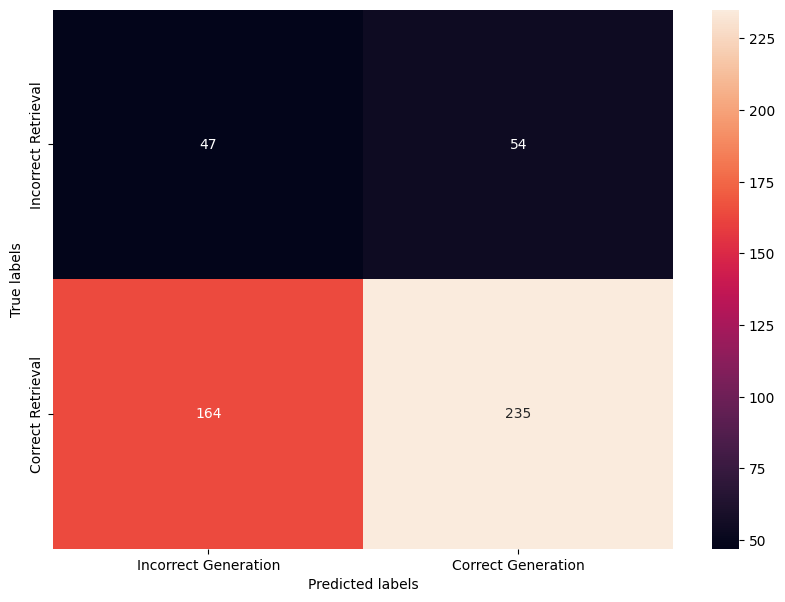

In [1004]:
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.yticks([0.5, 1.5], ['Incorrect Retrieval', 'Correct Retrieval'])
plt.xticks([0.5, 1.5], ['Incorrect Generation', 'Correct Generation'])
plt.show()

In [1005]:
errors_generated=df_generated_visual[~df_generated_visual['generated'].isin(['A', 'B', 'C', 'D','E'])][['correct_retrieving','gold_answer','generated']]
errors_generated

,correct_retrieving,gold_answer,generated
28,True,A,C3-C4
43,True,B,['EQ (5)']
65,True,C,5
148,True,A,ROBUSTVIT W/ DINO VITB
280,True,B,2
408,True,C,THEY DO NOT INTERSECT IN THE SHOWN RANGE
420,True,B,NBA
496,True,A,STEP 3


N. 28 the answer is correct, the letter has not been retrieved

N. 43 the answer is correct, the letter has not been retrieved

N. 65 (intresting). The model understand the image, but answers the opposite question ("after how many years goes up 0.1 concentration?")

N. 148 the answer is correct, the letter has not been retrieved

N. 280 if the number refers to the order of the choice (B is the second), is correct otherwise there is no explanation on when this "2" comes from.

N. 408 the answer is wrong. The graphs interesect twice and one of them is the C answer as the gold says.

N. 420 wrong answer, really tricky to say

N. 496 wrong gold label and wrong answer. Correct answer is D.


##### Analysis on each question

In [1006]:
q_ind=93

In [1007]:
ds.iloc[q_ind]['query']

'Based on the graph, how does the value of \\( 10^6x_{30} \\) change with an increase in \\( 10^6x_{29} \\)?'

In [1008]:
ds.iloc[q_ind]['options']

"['It decreases exponentially', 'It remains constant', 'It increases linearly', 'It increases exponentially', '-']"

In [1009]:
ds.iloc[q_ind]['answer']

'C'

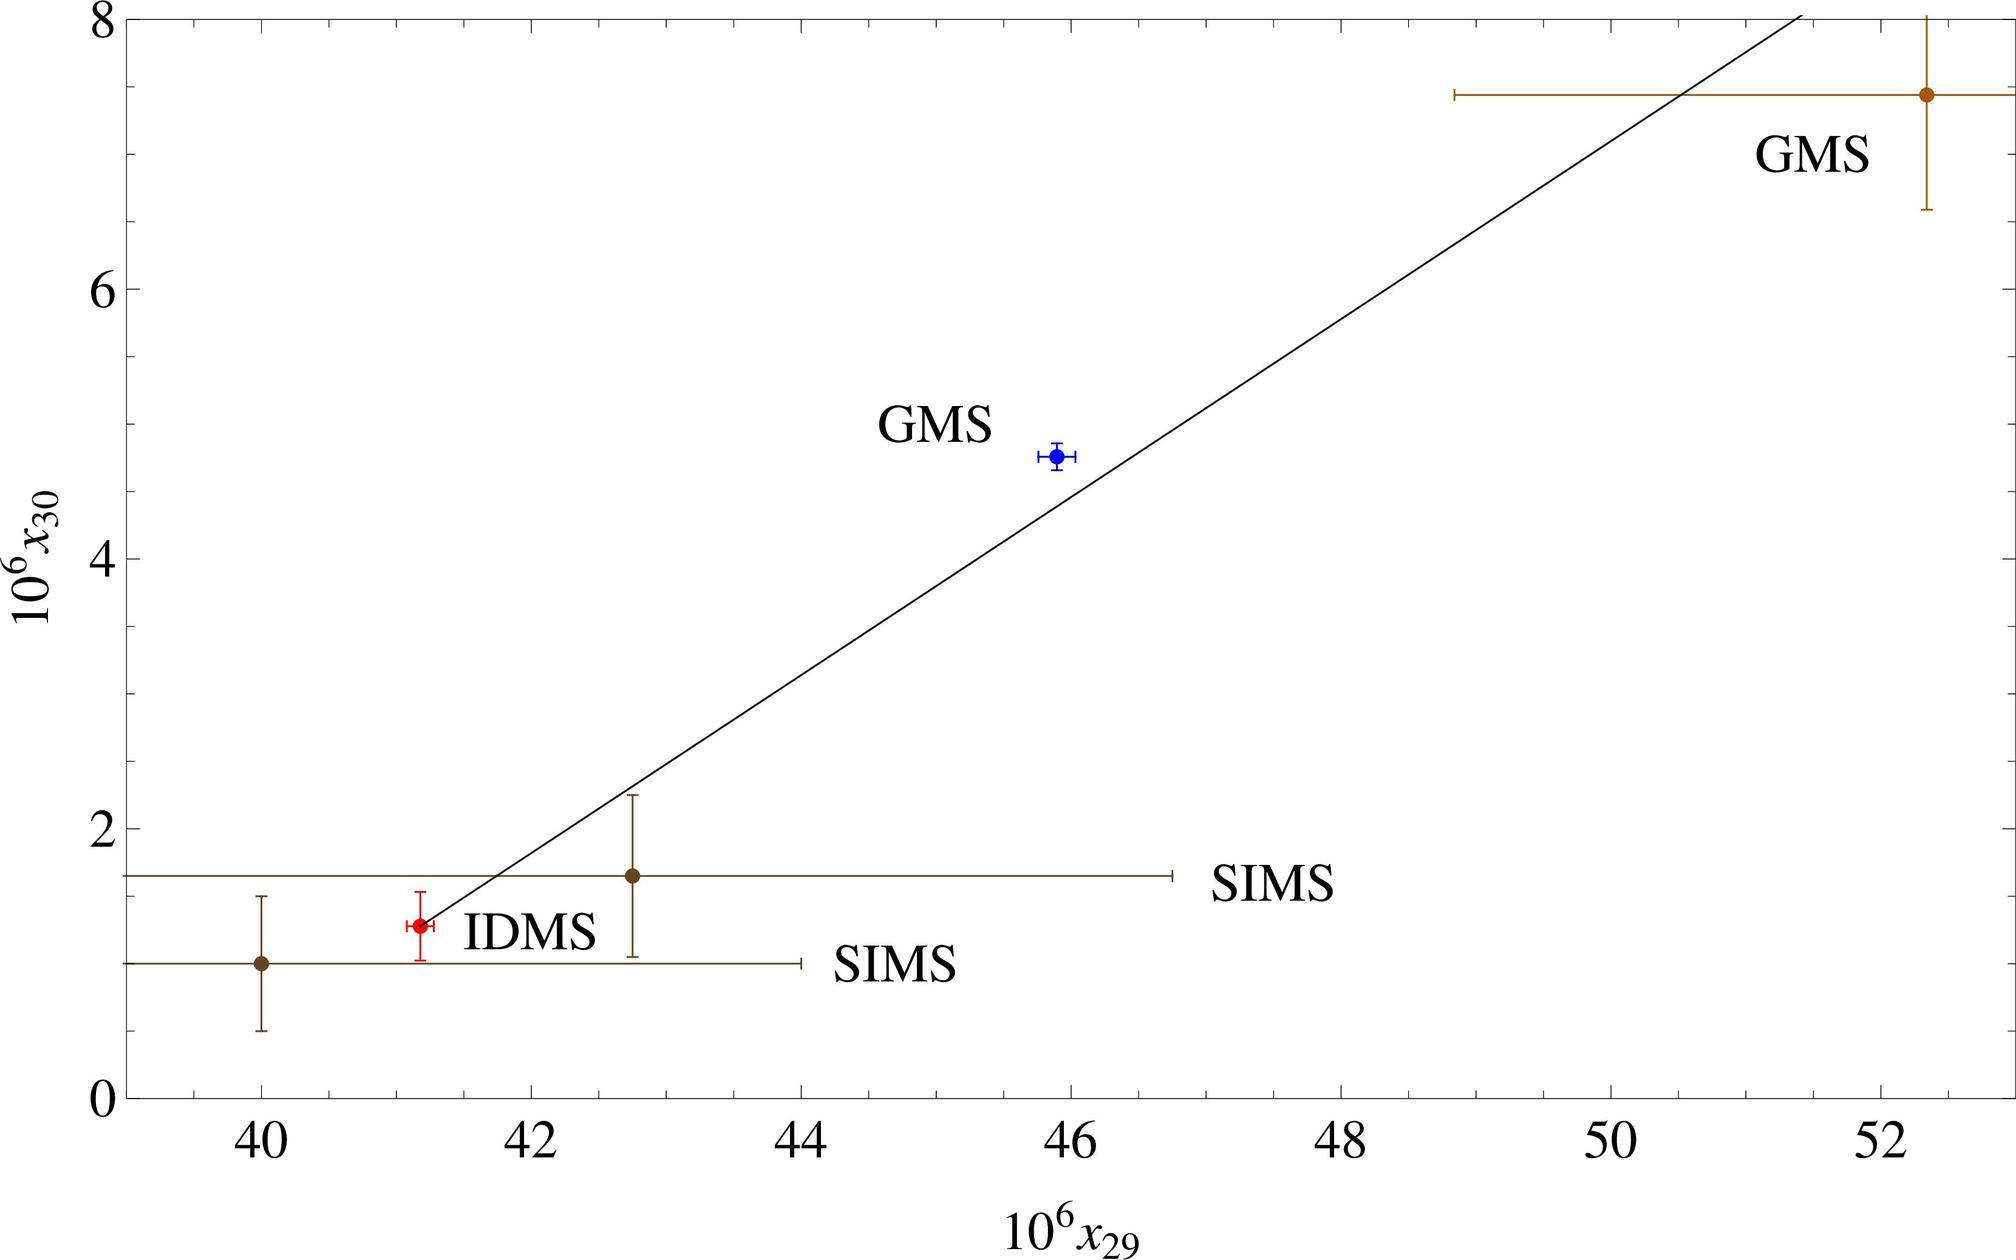

In [1010]:
Image.open(io.BytesIO(ds.iloc[q_ind]['image']['bytes']))

#### Text late interaction

In [1011]:
# Split the 'retrieved' column
df_generated_text_late_interaction[['retrieved_top1', 'retrieved_top2', 'retrieved_top3']] = pd.DataFrame(
    df_generated_text_late_interaction['retrieved'].tolist(),
    index=df_generated_text_late_interaction.index
    )


In [1012]:
for i, item in tqdm.tqdm(df_generated_text_late_interaction.iterrows(), total=df_generated_text_late_interaction.shape[0]):

    output_text = proc_img[proc_img['image_filename']==item['id_real']]['output_text'].values[0]
    df_generated_text_late_interaction.loc[i, 'retrieved_top1_check'] = True if item['retrieved_top1'] in output_text else False
    df_generated_text_late_interaction.loc[i, 'retrieved_top2_check'] = True if item['retrieved_top2'] in output_text else False
    df_generated_text_late_interaction.loc[i, 'retrieved_top3_check'] = True if item['retrieved_top3'] in output_text else False

100%|██████████| 500/500 [00:00<00:00, 4004.51it/s]


In [1013]:
acc_top1 = df_generated_text_late_interaction['retrieved_top1_check'].mean()
acc_top2 = df_generated_text_late_interaction['retrieved_top2_check'].mean()
acc_top3 = df_generated_text_late_interaction['retrieved_top3_check'].mean()

at_least_one = df_generated_text_late_interaction[['retrieved_top1_check', 'retrieved_top2_check', 'retrieved_top3_check']].any(axis=1)
at_least_two = df_generated_text_late_interaction[['retrieved_top1_check', 'retrieved_top2_check', 'retrieved_top3_check']].sum(axis=1).apply(lambda x: x>=2)
all_three = df_generated_text_late_interaction[['retrieved_top1_check', 'retrieved_top2_check', 'retrieved_top3_check']].all(axis=1)

In [1014]:
# Print all

print(f"Text Late Interaction Accuracy Top 1: {acc_top1}")
print(f"Text Late Interaction Accuracy Top 2: {acc_top2}")
print(f"Text Late Interaction Accuracy Top 3: {acc_top3}")
print(f"Text Late Interaction Accuracy At Least One: {at_least_one.mean()}")
print(f"Text Late Interaction Accuracy At Least Two: {at_least_two.mean()}")
print(f"Text Late Interaction Accuracy All Three: {all_three.mean()}")

Text Late Interaction Accuracy Top 1: 0.47
Text Late Interaction Accuracy Top 2: 0.362
Text Late Interaction Accuracy Top 3: 0.194
Text Late Interaction Accuracy At Least One: 0.556
Text Late Interaction Accuracy At Least Two: 0.344
Text Late Interaction Accuracy All Three: 0.126


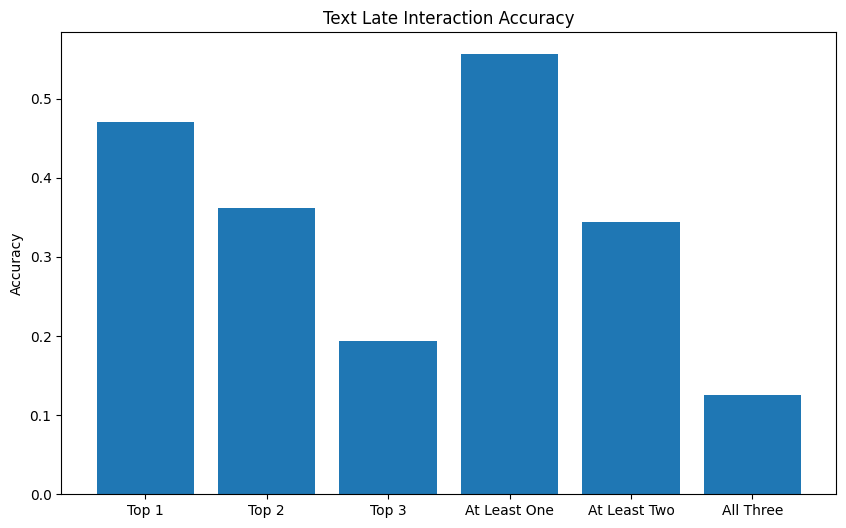

In [1015]:
# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(['Top 1', 'Top 2', 'Top 3', 'At Least One', 'At Least Two', 'All Three'], [acc_top1, acc_top2, acc_top3, at_least_one.mean(), at_least_two.mean(), all_three.mean()])
plt.ylabel('Accuracy')
plt.title('Text Late Interaction Accuracy')

# Show the plot
plt.show()

In [1016]:
# Number of occurences where top 1 is false and top 2 is true
print(f"Top 1 False and Top 2 True: {df_generated_text_late_interaction[(~df_generated_text_late_interaction['retrieved_top1_check']) & df_generated_text_late_interaction['retrieved_top2_check']].shape[0]}")

# Number of occurences where top 1 is false and top 3 is true
print(f"Top 1 False and Top 3 True: {df_generated_text_late_interaction[(~df_generated_text_late_interaction['retrieved_top1_check']) & df_generated_text_late_interaction['retrieved_top3_check']].shape[0]}")

# Number of occurences where top 2 is false and top 3 is true
print(f"Top 2 False and Top 3 True: {df_generated_text_late_interaction[(~df_generated_text_late_interaction['retrieved_top2_check']) & df_generated_text_late_interaction['retrieved_top3_check']].shape[0]}")

# Number of occurences where top 1 is false and top 2 and top 3 are true
print(f"Top 1 False and Top 2 and Top 3 True: {df_generated_text_late_interaction[(~df_generated_text_late_interaction['retrieved_top1_check']) & df_generated_text_late_interaction['retrieved_top2_check'] & df_generated_text_late_interaction['retrieved_top3_check']].shape[0]}")

# Number of occurences where top 1 is false and top 2 is false and top 3 is true
print(f"Top 1 False and Top 2 False and Top 3 True: {df_generated_text_late_interaction[(~df_generated_text_late_interaction['retrieved_top1_check']) & (~df_generated_text_late_interaction['retrieved_top2_check']) & df_generated_text_late_interaction['retrieved_top3_check']].shape[0]}")

Top 1 False and Top 2 True: 26
Top 1 False and Top 3 True: 21
Top 2 False and Top 3 True: 30
Top 1 False and Top 2 and Top 3 True: 4
Top 1 False and Top 2 False and Top 3 True: 97


In [1017]:
df_generated_text_late_interaction['correct_generating'] = df_generated_text_late_interaction['gold_answer']==df_generated_text_late_interaction['generated']

In [1018]:
print(f"Text Late Interaction Accuracy On at least one correct retrieval and correct generation: {df_generated_text_late_interaction['correct_generating'][at_least_one].mean()}")
print(f"Text Late Interaction Accuracy On at least two correct retrieval and correct generation: {df_generated_text_late_interaction['correct_generating'][at_least_two].mean()}")
print(f"Text Late Interaction Accuracy On all three correct retrieval and correct generation: {df_generated_text_late_interaction['correct_generating'][all_three].mean()}")

Text Late Interaction Accuracy On at least one correct retrieval and correct generation: 0.5215827338129496
Text Late Interaction Accuracy On at least two correct retrieval and correct generation: 0.5465116279069767
Text Late Interaction Accuracy On all three correct retrieval and correct generation: 0.5238095238095238


In [1019]:
print(f"Text Late Interaction Accuracy On Top 1 correct reetrieval correct generation: {df_generated_text_late_interaction['correct_generating'][df_generated_text_late_interaction['retrieved_top1_check']].mean()}")
print(f"Text Late Interaction Accuracy On Top 2 correct reetrieval correct generation: {df_generated_text_late_interaction['correct_generating'][df_generated_text_late_interaction['retrieved_top2_check']].mean()}")
print(f"Text Late Interaction Accuracy On Top 3 correct reetrieval correct generation: {df_generated_text_late_interaction['correct_generating'][df_generated_text_late_interaction['retrieved_top3_check']].mean()}")

Text Late Interaction Accuracy On Top 1 correct reetrieval correct generation: 0.5063829787234042
Text Late Interaction Accuracy On Top 2 correct reetrieval correct generation: 0.5524861878453039
Text Late Interaction Accuracy On Top 3 correct reetrieval correct generation: 0.5463917525773195


In [1020]:
df_generated_text_late_interaction.head()

,id_real,retrieved,gold_answer,generated,retrieved_top1,retrieved_top2,retrieved_top3,retrieved_top1_check,retrieved_top2_check,retrieved_top3_check,correct_generating
0,images/1810.10511_2.jpg,"[3. **Dotted Blue Line (f_spec ≠ 1, with corr....",C,B,"3. **Dotted Blue Line (f_spec ≠ 1, with corr.)...",The graph in the image is a plot of the surfac...,This indicates that as the state rank increase...,True,True,False,False
1,images/1107.3275_2.jpg,[The image is a bar chart that compares the pe...,D,C,The image is a bar chart that compares the per...,### FEB11\n- **PO**: Approximately 0.4% of use...,The graph is a line graph that plots the perce...,True,True,False,False
2,images/quant-ph9912091_0.jpg,[### Color Gradient:\n- The color bar on the r...,B,B,### Color Gradient:\n- The color bar on the ri...,### C: Streamlines\n- The right side of the im...,### Conclusion\nThe graphs appear to represent...,False,False,False,True
3,images/1808.10438_2.jpg,[- **Blue Curve (Point Source)**: This curve r...,B,B,- **Blue Curve (Point Source)**: This curve re...,This image is a scientific graph that appears ...,"- **Y-axis (Residual, mJy)**: This axis repres...",True,True,True,True
4,images/cond-mat0603861_2.jpg,[This suggests that as the network becomes mor...,A,D,This suggests that as the network becomes more...,The image presents a comparative analysis of t...,The line is a straight line that passes throug...,True,True,True,False


In [1021]:
cm = confusion_matrix(at_least_one, df_generated_text_late_interaction['correct_generating'])
cr=classification_report(at_least_one, df_generated_text_late_interaction['correct_generating'])

In [1022]:
print(cr)

              precision    recall  f1-score   support

       False       0.45      0.49      0.47       222
        True       0.56      0.52      0.54       278

    accuracy                           0.51       500
   macro avg       0.50      0.50      0.50       500
weighted avg       0.51      0.51      0.51       500



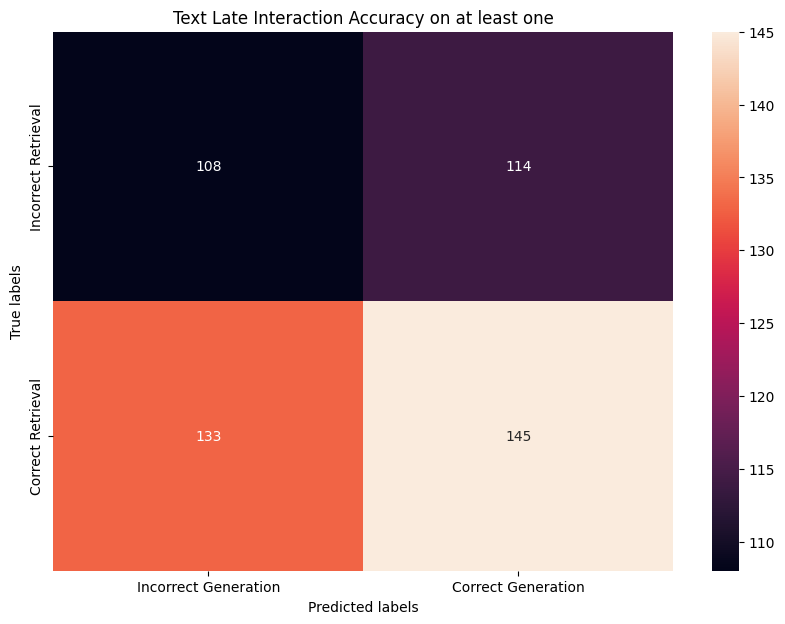

In [1023]:
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Text Late Interaction Accuracy on at least one')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.yticks([0.5, 1.5], ['Incorrect Retrieval', 'Correct Retrieval'])
plt.xticks([0.5, 1.5], ['Incorrect Generation', 'Correct Generation'])
plt.show()

In [1024]:
errors_generated=df_generated_text_late_interaction[~df_generated_text_late_interaction['generated'].isin(['A', 'B', 'C', 'D','E'])][['gold_answer','generated']]
errors_generated

,gold_answer,generated
11,C,\\( \\DELTA(T) \\) SHOWS NON-MONOTONIC BEHAVIO...
28,A,C3-C4
43,B,EQ (5)
49,C,"[""\\( N' \\) INCREASES AT A CONSTANT RATE AS \..."
65,C,10 YEARS
79,C,01 MEV
93,C,IT INCREASES EXPONENTIALLY
132,C,0 AND Π
163,D,['THE WIDTH OF THE GREEN AREA REPRESENTING A S...
193,B,20 KILOMETERS


N. 11 wrong answer

N. 28 the answer is correct, the letter has not been retrieved

N. 43 the answer is correct, the letter has not been retrieved

N. 49 the answer is correct, the letter has not been retrieved

N. 65 wrong answer, top1 and top2 correct

N. 79 wrong answer, only top 1 correct

N. 93 wrong answer, bad retrieval

N. 132 the answer is technically correct

N. 163 wrong answer, bad retrieval

N. 193 the answer is correct, the letter has not been retrieved

N. 280 the answer is correct, the letter has not been retrieved

N. 332 wrong answer, perfect retrieval. The image details are hard to see also for human to answer the question

N. 342 wrong answer, bad retrieval

N. 407 wrong answer, bad retrieval

N. 408 wrong answer, top1 and top2 correct

N. 420 the answer is correct, the letter has not been retrieved

N. 421 wrong answer, perfect retrieval. Error in the generation of the description of the image

N. 425 the answer is correct, the letter has not been retrieved.  The retrieval is always wrong

N. 496 right answer, top 1 retrieved good, wrong gold-answer.


##### Analysis on each question

In [1025]:
q_ind=496

In [1026]:
ds.iloc[q_ind]['query']

"At which step does the 'Fine-tuning' method reach its peak accuracy according to the graph?"

In [1027]:
ds.iloc[q_ind]['options']

"['Step 1', 'Step 2', 'Step 3', 'Step 4']"

In [1028]:
ds.iloc[q_ind]['answer']

'A'

In [1029]:
df_generated_text_late_interaction.iloc[q_ind]

id_real                                           images/2210.17322_0.jpg
retrieved               [The graph is titled "Zero-shot Image Classifi...
gold_answer                                                             A
generated                                                          STEP 4
retrieved_top1          The graph is titled "Zero-shot Image Classific...
retrieved_top2          This figure illustrates the process of reducin...
retrieved_top3          This process involves using a debiased pre-tra...
retrieved_top1_check                                                 True
retrieved_top2_check                                                False
retrieved_top3_check                                                False
correct_generating                                                  False
Name: 496, dtype: object

In [1030]:
for el in df_generated_text_late_interaction.iloc[q_ind]['retrieved']:
    print(el)
    print('--------------------------------')

The graph is titled "Zero-shot Image Classification," and it compares the accuracy of two different training methods: fine-tuning and joint training. The x-axis represents the number of steps, ranging from 1 to 4, while the y-axis represents the accuracy of the model in percentage.

The graph shows two lines: one for fine-tuning and one for joint training. The fine-tuning line starts at a low accuracy of approximately 5% and increases steadily with each step, reaching a maximum accuracy of around 25% after 4 steps. The joint training line starts at a higher accuracy of around 10% and also increases with each step, reaching a maximum accuracy of around 25% after 4 steps.

The graph demonstrates that joint training consistently outperforms fine-tuning in terms of accuracy, with a higher maximum accuracy and a faster increase in accuracy over the number of steps.
--------------------------------
This figure illustrates the process of reducing gender bias in BERT predictions. The figure is

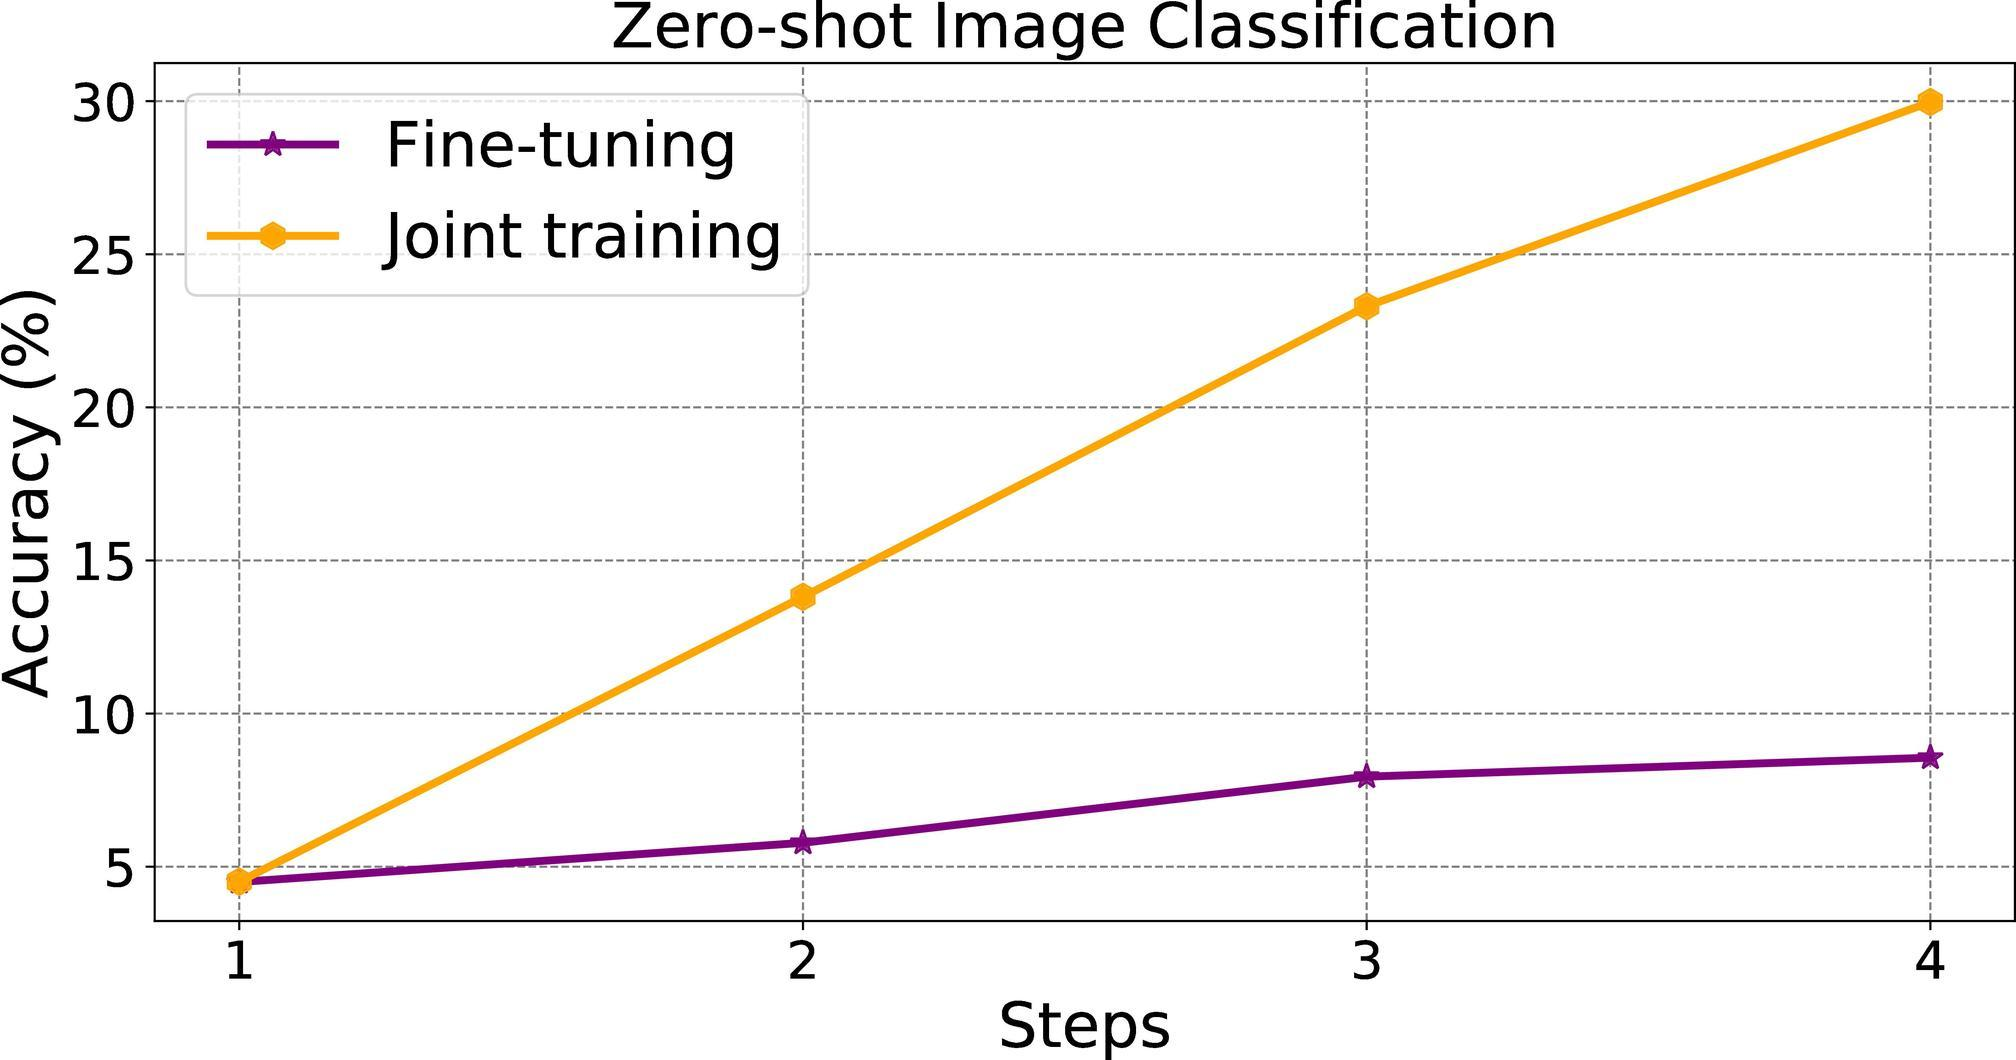

In [1031]:
Image.open(io.BytesIO(ds.iloc[q_ind]['image']['bytes']))

#### Text late chunking

In [1032]:
# Split the 'retrieved' column
df_generated_text_late_chunking[['id_retrieved_top1', 'id_retrieved_top2', 'id_retrieved_top3']] = pd.DataFrame(
    df_generated_text_late_chunking['id_retrieved'].tolist(),
    index=df_generated_text_late_chunking.index
    )
df_generated_text_late_chunking['id_retrieved_top1'] = df_generated_text_late_chunking['id_retrieved_top1'] == df_generated_text_late_chunking['id_real']
df_generated_text_late_chunking['id_retrieved_top2'] = df_generated_text_late_chunking['id_retrieved_top2'] == df_generated_text_late_chunking['id_real']
df_generated_text_late_chunking['id_retrieved_top3'] = df_generated_text_late_chunking['id_retrieved_top3'] == df_generated_text_late_chunking['id_real']

In [1033]:
acc_top1 = df_generated_text_late_chunking['id_retrieved_top1'].mean()
acc_top2 = df_generated_text_late_chunking['id_retrieved_top2'].mean()
acc_top3 = df_generated_text_late_chunking['id_retrieved_top3'].mean()

at_least_one = df_generated_text_late_chunking[['id_retrieved_top1', 'id_retrieved_top2', 'id_retrieved_top3']].any(axis=1)
at_least_two = df_generated_text_late_chunking[['id_retrieved_top1', 'id_retrieved_top2', 'id_retrieved_top3']].sum(axis=1).apply(lambda x: x>=2)
all_three = df_generated_text_late_chunking[['id_retrieved_top1', 'id_retrieved_top2', 'id_retrieved_top3']].all(axis=1)

In [1034]:
# Print all

print(f"Text Late Chunking Accuracy Top 1: {acc_top1}")
print(f"Text Late Chunking Accuracy Top 2: {acc_top2}")
print(f"Text Late Chunking Accuracy Top 3: {acc_top3}")
print(f"Text Late Chunking Accuracy At Least One: {at_least_one.mean()}")
print(f"Text Late Chunking Accuracy At Least Two: {at_least_two.mean()}")
print(f"Text Late Chunking Accuracy All Three: {all_three.mean()}")

Text Late Chunking Accuracy Top 1: 0.422
Text Late Chunking Accuracy Top 2: 0.354
Text Late Chunking Accuracy Top 3: 0.288
Text Late Chunking Accuracy At Least One: 0.478
Text Late Chunking Accuracy At Least Two: 0.372
Text Late Chunking Accuracy All Three: 0.214


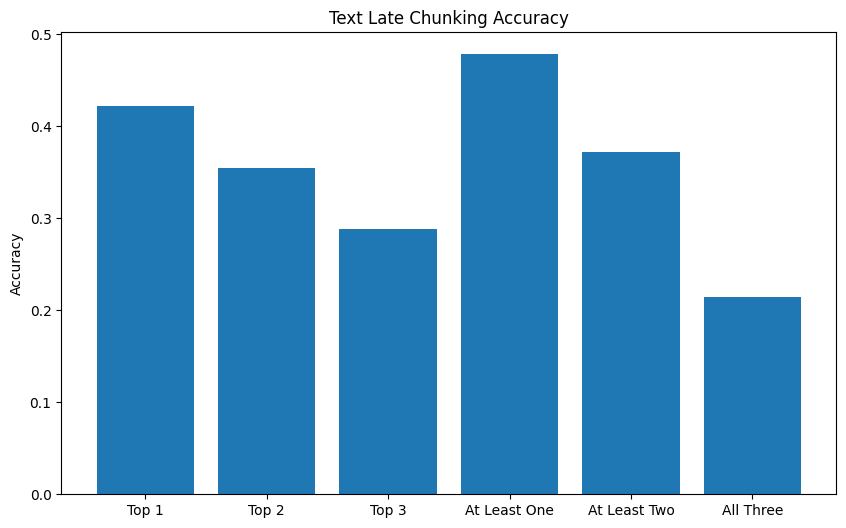

In [1035]:
# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(['Top 1', 'Top 2', 'Top 3', 'At Least One', 'At Least Two', 'All Three'], [acc_top1, acc_top2, acc_top3, at_least_one.mean(), at_least_two.mean(), all_three.mean()])
plt.ylabel('Accuracy')
plt.title('Text Late Chunking Accuracy')

# Show the plot
plt.show()

In [1036]:
# Number of occurences where top 1 is false and top 2 is true
print(f"Top 1 False and Top 2 True: {df_generated_text_late_chunking[(~df_generated_text_late_chunking['id_retrieved_top1']) & df_generated_text_late_chunking['id_retrieved_top2']].shape[0]}")

# Number of occurences where top 1 is false and top 3 is true
print(f"Top 1 False and Top 3 True: {df_generated_text_late_chunking[(~df_generated_text_late_chunking['id_retrieved_top1']) & df_generated_text_late_chunking['id_retrieved_top3']].shape[0]}")

# Number of occurences where top 2 is false and top 3 is true
print(f"Top 2 False and Top 3 True: {df_generated_text_late_chunking[(~df_generated_text_late_chunking['id_retrieved_top2']) & df_generated_text_late_chunking['id_retrieved_top3']].shape[0]}")

# Number of occurences where top 1 is false and top 2 and top 3 are true
print(f"Top 1 False and Top 2 and Top 3 True: {df_generated_text_late_chunking[(~df_generated_text_late_chunking['id_retrieved_top1']) & df_generated_text_late_chunking['id_retrieved_top2'] & df_generated_text_late_chunking['id_retrieved_top3']].shape[0]}")

# Number of occurences where top 1 is false and top 2 is false and top 3 is true
print(f"Top 1 False and Top 2 False and Top 3 True: {df_generated_text_late_chunking[(~df_generated_text_late_chunking['id_retrieved_top1']) & (~df_generated_text_late_chunking['id_retrieved_top2']) & df_generated_text_late_chunking['id_retrieved_top3']].shape[0]}")

Top 1 False and Top 2 True: 17
Top 1 False and Top 3 True: 18
Top 2 False and Top 3 True: 30
Top 1 False and Top 2 and Top 3 True: 7
Top 1 False and Top 2 False and Top 3 True: 11


In [1037]:
df_generated_text_late_chunking['correct_generating'] = df_generated_text_late_chunking['gold_answer']==df_generated_text_late_chunking['generated']

In [1038]:
print(f"Text Late Chunking Accuracy On at least one correct retrieval and correct generation: {df_generated_text_late_chunking['correct_generating'][at_least_one].mean()}")
print(f"Text Late Chunking Accuracy On at least two correct retrieval and correct generation: {df_generated_text_late_chunking['correct_generating'][at_least_two].mean()}")
print(f"Text Late Chunking Accuracy On all three correct retrieval and correct generation: {df_generated_text_late_chunking['correct_generating'][all_three].mean()}")

Text Late Chunking Accuracy On at least one correct retrieval and correct generation: 0.49372384937238495
Text Late Chunking Accuracy On at least two correct retrieval and correct generation: 0.46774193548387094
Text Late Chunking Accuracy On all three correct retrieval and correct generation: 0.4672897196261682


In [1039]:
print(f"Text Late Chunking Accuracy On Top 1 correct reetrieval correct generation: {df_generated_text_late_chunking['correct_generating'][df_generated_text_late_chunking['id_retrieved_top1']].mean()}")
print(f"Text Late Chunking Accuracy On Top 2 correct reetrieval correct generation: {df_generated_text_late_chunking['correct_generating'][df_generated_text_late_chunking['id_retrieved_top2']].mean()}")
print(f"Text Late Chunking Accuracy On Top 3 correct reetrieval correct generation: {df_generated_text_late_chunking['correct_generating'][df_generated_text_late_chunking['id_retrieved_top3']].mean()}")

Text Late Chunking Accuracy On Top 1 correct reetrieval correct generation: 0.5023696682464455
Text Late Chunking Accuracy On Top 2 correct reetrieval correct generation: 0.4576271186440678
Text Late Chunking Accuracy On Top 3 correct reetrieval correct generation: 0.4722222222222222


In [1040]:
df_generated_text_late_chunking.head()

,id_real,id_retrieved,gold_answer,generated,id_retrieved_top1,id_retrieved_top2,id_retrieved_top3,correct_generating
0,images/1810.10511_2.jpg,"[images/1810.10511_2.jpg, images/1810.10511_2....",C,B,True,True,True,False
1,images/1107.3275_2.jpg,"[images/1107.3275_2.jpg, images/1212.2055_0.jp...",D,D,True,False,True,True
2,images/quant-ph9912091_0.jpg,"[images/0902.0400_3.jpg, images/1806.05299_2.j...",B,B,False,False,False,True
3,images/1808.10438_2.jpg,"[images/1808.10438_2.jpg, images/1808.10438_2....",B,B,True,True,False,True
4,images/cond-mat0603861_2.jpg,"[images/cond-mat0603861_2.jpg, images/cond-mat...",A,D,True,True,True,False


In [1041]:
cm = confusion_matrix(at_least_one, df_generated_text_late_chunking['correct_generating'])
cr=classification_report(at_least_one, df_generated_text_late_chunking['correct_generating'])

In [1042]:
print(cr)

              precision    recall  f1-score   support

       False       0.54      0.54      0.54       261
        True       0.50      0.49      0.49       239

    accuracy                           0.52       500
   macro avg       0.52      0.52      0.52       500
weighted avg       0.52      0.52      0.52       500



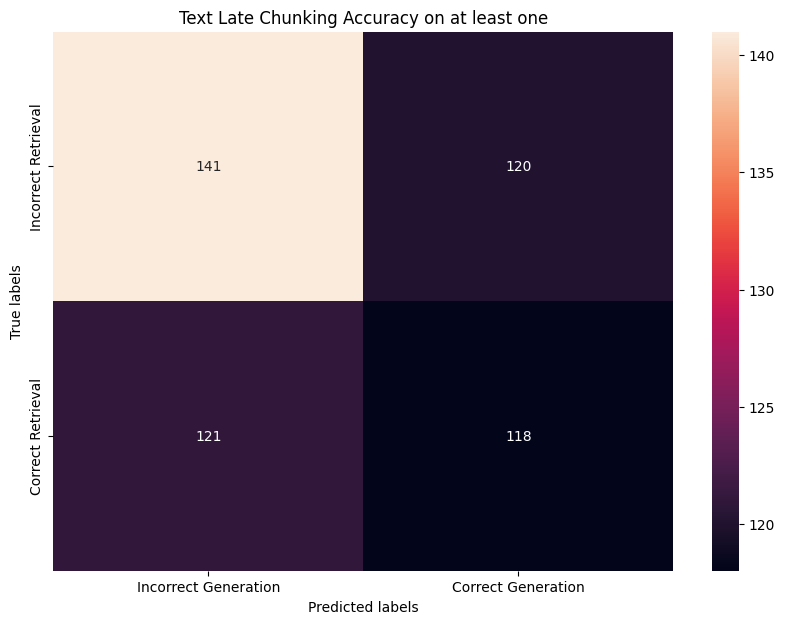

In [1043]:
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Text Late Chunking Accuracy on at least one')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.yticks([0.5, 1.5], ['Incorrect Retrieval', 'Correct Retrieval'])
plt.xticks([0.5, 1.5], ['Incorrect Generation', 'Correct Generation'])
plt.show()

In [1044]:
errors_generated=df_generated_text_late_chunking[~df_generated_text_late_chunking['generated'].isin(['A', 'B', 'C', 'D','E'])][['gold_answer','generated']]
errors_generated

,gold_answer,generated
11,C,\\( \\DELTA(T) \\) SHOWS NON-MONOTONIC BEHAVIO...
28,A,C3-C4
43,B,'EQ (5)'
49,C,"[""\\( N' \\) INCREASES AT A CONSTANT RATE AS \..."
65,C,10 YEARS
79,C,01 MEV
93,C,IT INCREASES EXPONENTIALLY
132,C,0 AND Π
146,D,D) THE FIGURE DOES NOT PROVIDE INFORMATION ABO...
148,A,ROBUSTVIT W/ DINO VITB


N. 11 wrong answer, bad retrieval

N. 28 the answer is correct, the letter has not been retrieved

N. 43 the answer is correct, the letter has not been retrieved

N. 49 the answer is correct, the letter has not been retrieved

N. 65 wrong answer, all retrieving correct. The generatioin of the description is not accurate as it should be and does not contain the answer.

N. 79 wrong answer, bad retrieval

N. 93 wrong answer, bad retrieval

N. 132 the answer is technically correct

N. 146 the answer is correct, the letter has not been retrieved

N. 148 the answer is correct, the letter has not been retrieved

N. 159 wrong answer, bad retrieval

N. 163 wrong answer, bad retrieval

N. 193 the answer is correct, the letter has not been retrieved

N. 246 wrong answer, bad retrieval

N. 280 the answer is correct, the letter has not been retrieved

N. 318 wrong answer, top1 and top2 correct. From the description could be difficult to infer the right answer

N. 326 wrong answer, perfect retrieval. The answer is correct if we analyze the description of the image, is hard to infer from that.

N. 332 wrong answer, perfect retrieval. The image details are hard to see also for human to answer the question

N. 342 wrong answer, bad retrieval

N. 363 the answer is correct, the letter has not been retrieved

N. 364 the answer is correct, the letter has not been retrieved

N. 407 wrong answer, only top2 correct. The description does not provide enough information.

N. 408 wrong answer, perfect retrieval

N. 420 wrong answer, perfect retrieval

N. 421 wrong answer, perfect retrieval. Error in the generation of the description of the image

N. 425 wrong answer, bad retrieval

N. 496 right answer, top 1 retrieved good, wrong gold-answer.


##### Analysis on each question

In [1045]:
q_ind=496

In [1046]:
ds.iloc[q_ind]['query']

"At which step does the 'Fine-tuning' method reach its peak accuracy according to the graph?"

In [1047]:
ds.iloc[q_ind]['options']

"['Step 1', 'Step 2', 'Step 3', 'Step 4']"

In [1048]:
ds.iloc[q_ind]['answer']

'A'

In [1049]:
df_generated_text_late_chunking.iloc[q_ind]

id_real                                         images/2210.17322_0.jpg
id_retrieved          [images/2210.17322_0.jpg, images/2210.17322_0....
gold_answer                                                           A
generated                                                        STEP 4
id_retrieved_top1                                                  True
id_retrieved_top2                                                  True
id_retrieved_top3                                                 False
correct_generating                                                False
Name: 496, dtype: object

In [1050]:
for el in df_generated_text_late_interaction.iloc[q_ind]['retrieved']:
    print(el)
    print('--------------------------------')

The graph is titled "Zero-shot Image Classification," and it compares the accuracy of two different training methods: fine-tuning and joint training. The x-axis represents the number of steps, ranging from 1 to 4, while the y-axis represents the accuracy of the model in percentage.

The graph shows two lines: one for fine-tuning and one for joint training. The fine-tuning line starts at a low accuracy of approximately 5% and increases steadily with each step, reaching a maximum accuracy of around 25% after 4 steps. The joint training line starts at a higher accuracy of around 10% and also increases with each step, reaching a maximum accuracy of around 25% after 4 steps.

The graph demonstrates that joint training consistently outperforms fine-tuning in terms of accuracy, with a higher maximum accuracy and a faster increase in accuracy over the number of steps.
--------------------------------
This figure illustrates the process of reducing gender bias in BERT predictions. The figure is

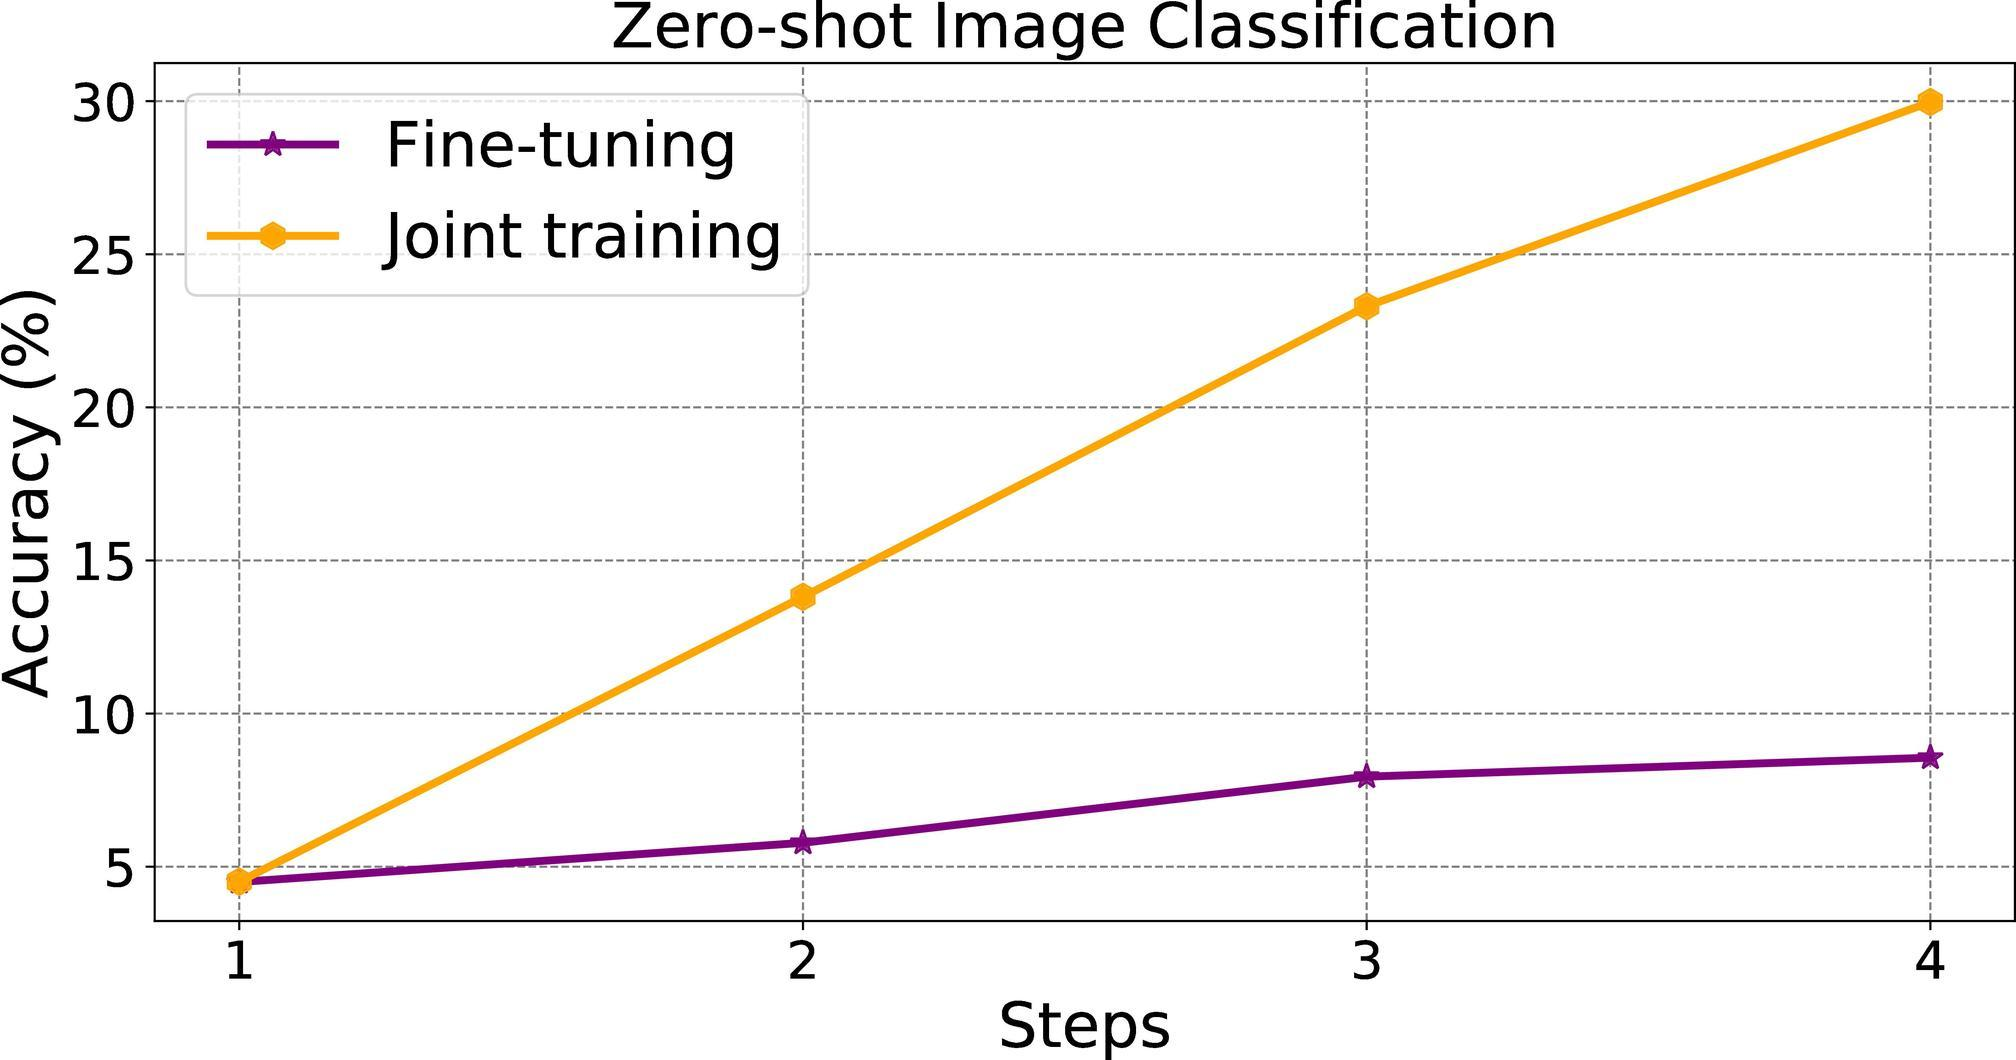

In [1051]:
Image.open(io.BytesIO(ds.iloc[q_ind]['image']['bytes']))

### Analysis @ 1

#### Imports

In [1052]:
ds = pd.read_parquet(PATH+'data/test-00000-of-00001.parquet')

In [1053]:
df_generated = pd.read_parquet(PATH+'data/df_generated_top_1.parquet')
df_generated['retrieved'] = df_generated['retrieved'].apply(lambda x: ast.literal_eval(x))
df_generated.loc[500:,'id_retrieved'] = df_generated.loc[500:,'id_retrieved'].apply(lambda x: ast.literal_eval(x))
df_generated.loc[1:,'generated'] = df_generated.loc[1:,'generated'].apply(lambda x: ast.literal_eval(x))
df_generated['generated'] = df_generated['generated'] \
                                            .apply(lambda x: x[0] if type(x) is list else x) \
                                            .apply(lambda x: x.replace('\n',''))   \
                                            .apply(lambda x: x.upper()
                                                                .replace(',', '')
                                                                .replace('.', '')
                                                                .replace(';', '')
                                                                .replace(':', '')
                                                                )


In [1054]:
errors_gold_answer=df_generated[~df_generated['gold_answer'].isin(['A', 'B', 'C', 'D','E'])]['gold_answer']
errors_gold_answer

33                                             B) 0.1 rad
34                                    D) College football
40       B. Specific physical components of the equipment
49      C. \( N' \) increases at a constant rate as \(...
51                                               B) Biere
                              ...                        
1464                                             C. 6 meV
1471                     C. Instances of alignment errors
1479                                             B. 32 mW
1494         B) Lower value ranges occur more frequently.
1499                               B) Ar+ and He-Ne laser
Name: gold_answer, Length: 186, dtype: object

In [1055]:
# Address wrong gold labels
df_generated.loc[errors_gold_answer.index, 'gold_answer'] = df_generated.loc[errors_gold_answer.index, 'gold_answer'].apply(lambda x: x[0])

In [1056]:
proc_img = pd.read_parquet(PATH+'data/processed_images.parquet')
proc_img['output_text'] = proc_img['output_text'].apply(lambda x: x[0])

In [1057]:
df_generated_visual = df_generated.iloc[:500][['id_real','id_retrieved','gold_answer','generated']]
df_generated_text_late_interaction = df_generated.iloc[500:1000][['id_real','retrieved','gold_answer','generated']].reset_index(drop=True)
df_generated_text_late_chunking = df_generated.iloc[1000:][['id_real','id_retrieved', 'gold_answer','generated']].reset_index(drop=True)

#### Text late interaction

In [1058]:
# Split the 'retrieved' column
df_generated_text_late_interaction[['retrieved_top1', 'retrieved_top2', 'retrieved_top3']] = pd.DataFrame(
    df_generated_text_late_interaction['retrieved'].tolist(),
    index=df_generated_text_late_interaction.index
    )


In [1059]:
for i, item in tqdm.tqdm(df_generated_text_late_interaction.iterrows(), total=df_generated_text_late_interaction.shape[0]):

    output_text = proc_img[proc_img['image_filename']==item['id_real']]['output_text'].values[0]
    df_generated_text_late_interaction.loc[i, 'retrieved_top1_check'] = True if item['retrieved_top1'] in output_text else False

100%|██████████| 500/500 [00:00<00:00, 6583.02it/s]


In [1060]:
del df_generated_text_late_interaction['retrieved_top2']
del df_generated_text_late_interaction['retrieved_top3']

In [1061]:
acc_top1 = df_generated_text_late_interaction['retrieved_top1_check'].mean()

In [1062]:
# Print all

print(f"Text Late Interaction Accuracy Top 1: {acc_top1}")

Text Late Interaction Accuracy Top 1: 0.47


In [1063]:
df_generated_text_late_interaction['correct_generating'] = df_generated_text_late_interaction['gold_answer']==df_generated_text_late_interaction['generated']

In [1064]:
print(f"Text Late Interaction Accuracy On Top 1 correct reetrieval correct generation: {df_generated_text_late_interaction['correct_generating'][df_generated_text_late_interaction['retrieved_top1_check']].mean()}")

Text Late Interaction Accuracy On Top 1 correct reetrieval correct generation: 0.4978723404255319


In [1065]:
df_generated_text_late_interaction.head()

,id_real,retrieved,gold_answer,generated,retrieved_top1,retrieved_top1_check,correct_generating
0,images/1810.10511_2.jpg,"[3. **Dotted Blue Line (f_spec ≠ 1, with corr....",C,B,"3. **Dotted Blue Line (f_spec ≠ 1, with corr.)...",True,False
1,images/1107.3275_2.jpg,[The image is a bar chart that compares the pe...,D,C,The image is a bar chart that compares the per...,True,False
2,images/quant-ph9912091_0.jpg,[### Color Gradient:\n- The color bar on the r...,B,B,### Color Gradient:\n- The color bar on the ri...,False,True
3,images/1808.10438_2.jpg,[- **Blue Curve (Point Source)**: This curve r...,B,B,- **Blue Curve (Point Source)**: This curve re...,True,True
4,images/cond-mat0603861_2.jpg,[This suggests that as the network becomes mor...,A,D,This suggests that as the network becomes more...,True,False


In [1066]:
df_generated_text_late_interaction['retrieved_top1_check']= df_generated_text_late_interaction['retrieved_top1_check'].astype(bool)

In [1067]:
cm = confusion_matrix(df_generated_text_late_interaction['retrieved_top1_check'], df_generated_text_late_interaction['correct_generating'])
cr=classification_report(df_generated_text_late_interaction['retrieved_top1_check'], df_generated_text_late_interaction['correct_generating'])

In [1068]:
print(cr)

              precision    recall  f1-score   support

       False       0.55      0.55      0.55       265
        True       0.49      0.50      0.50       235

    accuracy                           0.52       500
   macro avg       0.52      0.52      0.52       500
weighted avg       0.52      0.52      0.52       500



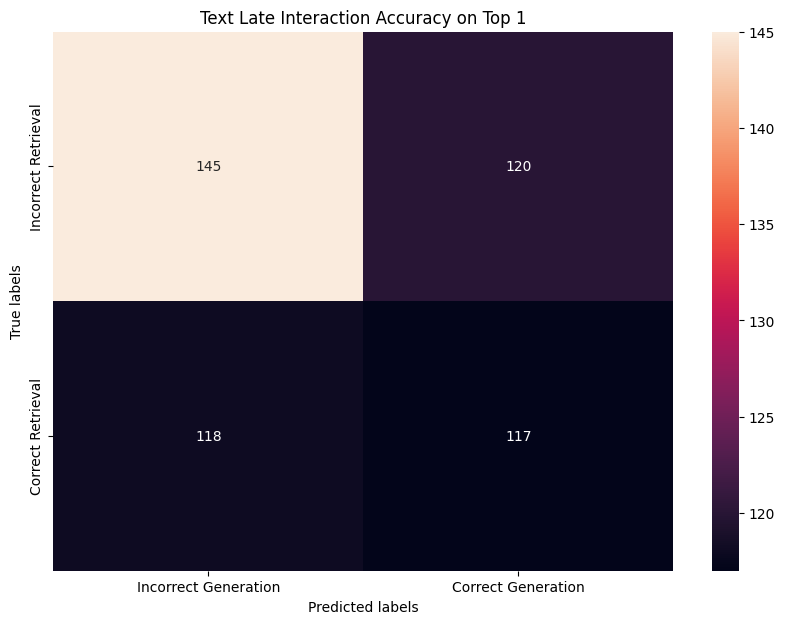

In [1069]:
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Text Late Interaction Accuracy on Top 1')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.yticks([0.5, 1.5], ['Incorrect Retrieval', 'Correct Retrieval'])
plt.xticks([0.5, 1.5], ['Incorrect Generation', 'Correct Generation'])
plt.show()

#### Text late chunking

In [1070]:
# Split the 'retrieved' column
df_generated_text_late_chunking[['id_retrieved_top1', 'id_retrieved_top2', 'id_retrieved_top3']] = pd.DataFrame(
    df_generated_text_late_chunking['id_retrieved'].tolist(),
    index=df_generated_text_late_chunking.index
    )
df_generated_text_late_chunking['id_retrieved_top1'] = df_generated_text_late_chunking['id_retrieved_top1'] == df_generated_text_late_chunking['id_real']

del df_generated_text_late_chunking['id_retrieved_top2']
del df_generated_text_late_chunking['id_retrieved_top3']

In [1071]:
acc_top1 = df_generated_text_late_chunking['id_retrieved_top1'].mean()

In [1072]:
# Print all

print(f"Text Late Interaction Accuracy Top 1: {acc_top1}")

Text Late Interaction Accuracy Top 1: 0.422


In [1073]:
df_generated_text_late_chunking['correct_generating'] = df_generated_text_late_chunking['gold_answer']==df_generated_text_late_chunking['generated']

In [1074]:
print(f"Text Late Interaction Accuracy On Top 1 correct reetrieval correct generation: {df_generated_text_late_chunking['correct_generating'][df_generated_text_late_chunking['id_retrieved_top1']].mean()}")

Text Late Interaction Accuracy On Top 1 correct reetrieval correct generation: 0.4834123222748815


In [1075]:
df_generated_text_late_chunking.head()

,id_real,id_retrieved,gold_answer,generated,id_retrieved_top1,correct_generating
0,images/1810.10511_2.jpg,"[images/1810.10511_2.jpg, images/1810.10511_2....",C,C,True,True
1,images/1107.3275_2.jpg,"[images/1107.3275_2.jpg, images/1212.2055_0.jp...",D,D,True,True
2,images/quant-ph9912091_0.jpg,"[images/0902.0400_3.jpg, images/1806.05299_2.j...",B,B,False,True
3,images/1808.10438_2.jpg,"[images/1808.10438_2.jpg, images/1808.10438_2....",B,B,True,True
4,images/cond-mat0603861_2.jpg,"[images/cond-mat0603861_2.jpg, images/cond-mat...",A,D,True,False


In [1076]:
cm = confusion_matrix(df_generated_text_late_chunking['id_retrieved_top1'], df_generated_text_late_chunking['correct_generating'])
cr=classification_report(df_generated_text_late_chunking['id_retrieved_top1'], df_generated_text_late_chunking['correct_generating'])

In [1077]:
print(cr)

              precision    recall  f1-score   support

       False       0.57      0.51      0.54       289
        True       0.42      0.48      0.45       211

    accuracy                           0.50       500
   macro avg       0.50      0.50      0.49       500
weighted avg       0.51      0.50      0.50       500



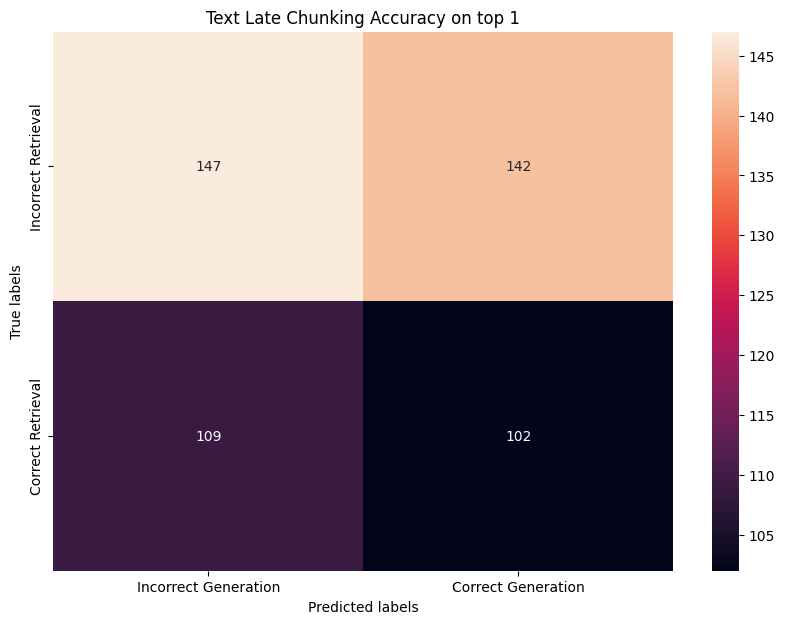

In [1078]:
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Text Late Chunking Accuracy on top 1')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.yticks([0.5, 1.5], ['Incorrect Retrieval', 'Correct Retrieval'])
plt.xticks([0.5, 1.5], ['Incorrect Generation', 'Correct Generation'])
plt.show()